# Gamma-Vanna- Charm Scalping 

FGV CRYPTO:
- Guilherme Regueira
- Calebe Soares
-Francisco Hansen
-Isaque Sathler
-Lucas Rocha

# Importando bibliotecas

In [1]:
import sympy as sp
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("dark_background")
import math

# Importando e visualizando os dados

Os dados abaixo representam a volatilidade implícita dos contratos de ETH-USD interpoladas, retiradas do seguinte link:  https://t3index.com/indices/bit-vol/

Apenas capturei os dados do periodo 04/06/2020 - 13/11/2021 , e acrescentei a coluna DTE, visto que a estrátegia que vamos utilizar consiste na montagem de um Straddle nas opções com 45 dias para o vencimento e a desmontagem da estrutura aos 22 dias para o vencimento

In [56]:
ethereum_data=pd.read_excel("ethvol(2).xlsx")
ethereum_data=ethereum_data.set_index("Date")
ethereum_data["IV"]=ethereum_data["IV"].astype(float)
ethereum_data

,IV,DTE
Date,,
2020-06-04 00:00:00,82.06,45
2020-06-05 00:00:00,74.73,44
2020-06-06 00:00:00,74.33,43
2020-06-07 00:00:00,74.62,42
2020-06-08 00:00:00,72.71,41
...,...,...
2021-11-09 00:00:00,108.00,26
2021-11-10 00:00:00,107.34,25
2021-11-11 00:00:00,108.96,24


Criando uma coluna para deixar o IV em percentual

In [59]:
ethereum_data["IV%"]=ethereum_data["IV"]/100
ethereum_data=ethereum_data.dropna()
ethereum_data

,IV,DTE,IV%
Date,,,
2020-06-04 00:00:00,82.06,45,0.8206
2020-06-05 00:00:00,74.73,44,0.7473
2020-06-06 00:00:00,74.33,43,0.7433
2020-06-07 00:00:00,74.62,42,0.7462
2020-06-08 00:00:00,72.71,41,0.7271
...,...,...,...
2021-11-09 00:00:00,108.00,26,1.0800
2021-11-10 00:00:00,107.34,25,1.0734
2021-11-11 00:00:00,108.96,24,1.0896


# Importando os preços históricos de ETH-USD

Importando os preços históricos de ETH-USD no período de 04/06/2020 - 13/11/2021 a partir do link: https://finance.yahoo.com/quote/ETH-USD/history?p=ETH-USD

In [60]:
ethereum=pd.read_csv("ETH-USD(2).csv",sep=",")
ethereum=ethereum.set_index("Date")
ethereum

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-04,244.105286,245.928970,236.765305,244.426392,244.426392,10170414304
2020-06-05,244.349594,247.329498,240.682053,241.221985,241.221985,9293963914
2020-06-06,241.201355,245.981049,239.724533,241.931320,241.931320,8114873845
2020-06-07,241.908081,245.435257,236.325256,245.167252,245.167252,9544883157
2020-06-08,245.178574,246.644196,241.542191,246.309906,246.309906,8076783299
...,...,...,...,...,...,...
2021-11-09,4810.071289,4837.589355,4718.039063,4735.068848,4735.068848,20834172627
2021-11-10,4733.362793,4859.502930,4485.093262,4636.174316,4636.174316,22748160545
2021-11-11,4635.453613,4778.059082,4580.990234,4730.384277,4730.384277,17933201129


# Setando Black & Scholes

Setando os simbolos utilizados na equação de Black & Scholes pelo Sympy

In [9]:
x, y ,z, S, q, T, r,K,v =sp.symbols("x y z S q T r K v ")
(x,y,z,S,q,T,r,K,v)

(x, y, z, S, q, T, r, K, v)

Descrevendo a função cumulativa de  densidade de probabilidade (distnormp no excel)

In [10]:
def CDF(value):
    CDF = integrate((1/sqrt(2*pi*1))*exp(-1*((x-0)**2)/(2*1**2)),(x,-oo,value))
    return(N(CDF))


Setando d1 & d2, que são paramêtros utilizados na equação de Black & Scholes

In [11]:
d1=(ln(S/K)+(r-q+0.5*v**2)*T)/(v*sqrt(T))
d2=d1-v*sqrt(T)

Efetivamente descrevendo a equação de Black& Scholes e visualizando

In [12]:
black_scholes_call= S*exp(-q*T)*CDF(d1)-exp(-r*T)*K*CDF(d2)
black_scholes_put= exp(-r*T)*K*CDF(-d2) -S*exp(-q*T) *CDF(-d1)
black_scholes_call 

# ERF  = Cumulative Probability Density Function

-K*(0.5*erf(sqrt(2)*(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))/2) + 0.5)*exp(-T*r) + S*(0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q)

In [13]:
black_scholes_put

K*(0.5*erf(sqrt(2)*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))/2) + 0.5)*exp(-T*r) - S*(0.5 - 0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)))*exp(-T*q)

# Setando o Delta da Call & Put

O delta mensura a variação no preço das opções a partir do crescimento de $ 1.00 no preço do ativo (ETH-USD), na nossa estrátegia é a grega mais importante e objetivamos zerar o nosso delta, com o objetivo de não nos posicionarmos direcionalmente em ETH-USD. Portanto buscamos fazer o Delta Hedge

In [14]:
delta_call=black_scholes_call.diff(S)
delta_call

-0.5*sqrt(2)*K*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) + (0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v)

In [15]:
delta_put=black_scholes_put.diff(S)
delta_put

-0.5*sqrt(2)*K*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) + (0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) - 0.5)*exp(-T*q) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v)

# Iniciando o estudo da estrátegia

A estratégia de Gamma Scalping ou como o grupo prefere denominar Gamma - Vanna - Charm Scalping, consiste na montagem de um Straddle, ou seja a compra de uma Call e Put com strikes o mais próximos possíveis do preço do papel, foi escolhido e será justificado posteriormente a montagem dessa estrutura quando as opções restarem 45 dias para o vencimento, e a desmontagem ocorre com 22 dias para o vencimento, conforme ocorre variação no preço do ativo (Gamma), volatilidade implícita (Vanna) e passagem do tempo (Charm) o delta da nossa estrutura varia, e buscamos aqui criar uma estrátegia que seja não direcional ao mercado, portanto necessitamos fazer um Delta Hedge em nossa estrutura comprando ou vendendo ativo (ETH-USD) objetivando zerar o delta de nossa estrutura, scalpando dessa forma a volatilidade real do papel (diferente da volatilidade implícita), essa estrátegia funciona bem em ativos volatéis, e devido a recente possibilidade de se operar opções com criptomoedas essa ideia é bastante inovadora

# Criando os Strikes

É necessário simular os strikes existentes na option chain de ETH-USD, para isso toda vez que o a coluna "DTE"(Days to Expiration) em nossa tabela for igual a 45 criaremos um strike ficticio de opções com o valor que o ETH-USD fechou no dia

In [68]:
strike_list=[]
for x in range(len(ethereum_data["IV"])):
    if ethereum_data["DTE"].iloc[x]==45:     
        strike_list.append(ethereum["Adj Close"].iloc[x])
        ultimo=ethereum["Adj Close"].iloc[x]
    else:
        strike_list.append(ultimo)

In [69]:
strike_list=pd.DataFrame(pd.Series(strike_list))
strike_list=strike_list.rename(columns={0:"Strike"})
strike_list

,Strike
0,244.426392
1,244.426392
2,244.426392
3,244.426392
4,244.426392
...,...
523,4054.322754
524,4054.322754
525,4054.322754
526,4054.322754


# Criando os preços das opções a partir da IV

Por meio da Implied Volatility é possível determinar o preço que as opções estão sendo negociadas, bastando preencher os outros paramêtros, uma vez que temos todos eles, faltaria apenas a taxa de juros livre de risco que não possuimos acesso mas o impacto dela no delta e preço de nossas opções não é tão relevante como mostraremos mais adiante e a lógica por trás da simulação é a mesma

In [70]:
call_price=[]
put_price=[]
for a in range(len(ethereum_data["IV"])):
    call_price.append(N(black_scholes_call.subs(S,ethereum["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(ethereum_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(ethereum_data["IV"].iloc[a])/100).subs(r,0.05)))
    put_price.append(N(black_scholes_put.subs(S,ethereum["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(ethereum_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(ethereum_data["IV"].iloc[a])/100).subs(r,0.05)))

In [71]:
call_price=pd.DataFrame(pd.Series(call_price))
put_price=pd.DataFrame(pd.Series(put_price))
options_prices=call_price

In [72]:
options_prices["Put"]=put_price
options_prices=options_prices.rename(columns={0:"Call"})
options_prices

,Call,Put
0,28.6707972756744,27.1686937704864
1,24.1304449693243,25.8660280433013
2,24.0847249293944,25.1442571416951
3,25.6698627725900,23.5267516829978
4,25.3904476010952,22.1379757700180
...,...,...
523,924.070750564715,228.910287582101
524,838.921781493892,243.209300525485
525,906.707726269318,217.338810135380
526,855.132675285252,229.586403816436


# Inserindo o Delta no DataFrame

In [73]:
call_delta=[]
put_delta=[]
for a in range(len(ethereum_data["IV"])):
    call_delta.append(N(delta_call.subs(S,ethereum["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(ethereum_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(ethereum_data["IV"].iloc[a])/100).subs(r,0.05)))
    put_delta.append(N(delta_put.subs(S,ethereum["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(ethereum_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(ethereum_data["IV"].iloc[a])/100).subs(r,0.05)))

In [74]:
call_delta=pd.DataFrame(pd.Series(call_delta))
put_delta=pd.DataFrame(pd.Series(put_delta))
options_prices["Call_Delta"]=call_delta
options_prices["Put_Delta"]=put_delta
options_prices.head()

,Call,Put,Call_Delta,Put_Delta
0,28.6707972756744,27.1686937704864,0.565709136574348,-0.434290863425652
1,24.1304449693243,25.8660280433013,0.540661500112162,-0.459338499887838
2,24.0847249293944,25.1442571416951,0.543967253935622,-0.456032746064378
3,25.6698627725900,23.5267516829978,0.564050966377756,-0.435949033622244
4,25.3904476010952,22.1379757700180,0.570007437529494,-0.429992562470506


Inserindo o Delta total da estrutrua no Dataframe, que seria a somatória entre o delta da Call e o Delta da Put, teoricamente se aproximaria bastante do zero, ou seja a estrutura tenderia a ficar não direcional, mas isso não acontece na prática e pode ser ajustando posteriomente no balanceamento dinâmico de nossa estrutura

In [75]:
options_prices["Total_Delta"]=options_prices["Call_Delta"]*1+options_prices["Put_Delta"]*1
options_prices.head()

,Call,Put,Call_Delta,Put_Delta,Total_Delta
0,28.6707972756744,27.1686937704864,0.565709136574348,-0.434290863425652,0.131418273148697
1,24.1304449693243,25.8660280433013,0.540661500112162,-0.459338499887838,0.0813230002243244
2,24.0847249293944,25.1442571416951,0.543967253935622,-0.456032746064378,0.0879345078712430
3,25.6698627725900,23.5267516829978,0.564050966377756,-0.435949033622244,0.128101932755512
4,25.3904476010952,22.1379757700180,0.570007437529494,-0.429992562470506,0.140014875058987


# Backtest

Nesse exemplo simulou-se que inicialmente o usuário possuia 100.000 e as taxas de corretagem para montagem da estrutura seriam de 0.5% (na deribit como mostrado na apresentação essa taxa é de 0,03%) , além disso o máximo a se gastar nas opções é 60% do seu budget máximo, visto que é necessário ter dinheiro em caixa caso seja necessário comprar ETH-USD para manejar o delta da estrutura

In [76]:
cash=100000
Buy, Sell =[],[]
Buy_Ativo , Sell_Ativo =[],[]
cash_data_data=[]
df_log=pd.DataFrame()
df_log2=pd.DataFrame()
signal=0
amount=cash
cash_data=[cash]
trades=0
comission=0.005 # 0.5%
ativo_delta=0
ethusd=0
for i in range(len(ethereum_data["IV"])):
    if ethereum_data["DTE"].iloc[i]==45:
        comissao=comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])
        maximo=math.trunc(0.6*cash/(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]+comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])))
        cash-=maximo*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]+comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]))
        price=options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]
        a_row=pd.Series(["Buy",ethereum.index[i],price,maximo,price*maximo,comissao])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True) 
        signal+=1     
    if ethereum_data["DTE"].iloc[i]==22:
        cash+=maximo*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])
        price=options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]
        a_row=pd.Series(["Sell",ethereum.index[i],price,maximo,price*maximo,0])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True) 
        signal=0
    if options_prices["Total_Delta"].iloc[i]+ativo_delta>0: # + delta do ativo
        cash+=ethereum["Adj Close"].iloc[i]*options_prices["Total_Delta"].iloc[i]
        price=ethereum["Adj Close"].iloc[i]
        ativo_delta-=options_prices["Total_Delta"].iloc[i]
        a_row2=pd.Series(["Sell",ethereum.index[i],price,options_prices["Total_Delta"].iloc[i],price*options_prices["Total_Delta"].iloc[i],0])
        row_df2=pd.DataFrame([a_row2])
        df_log2 = pd.concat([row_df2, df_log2], ignore_index=True) 
        ethusd+=options_prices["Total_Delta"].iloc[i]
    if options_prices["Total_Delta"].iloc[i]+ativo_delta<0:   
        cash-=ethereum["Adj Close"].iloc[i]*options_prices["Total_Delta"].iloc[i]
        price=ethereum["Adj Close"].iloc[i]
        ativo_delta+=options_prices["Total_Delta"].iloc[i]
        a_row2=pd.Series(["Buy",ethereum.index[i],price,options_prices["Total_Delta"].iloc[i],price*options_prices["Total_Delta"].iloc[i],0])
        row_df2=pd.DataFrame([a_row2])
        df_log2 = pd.concat([row_df2, df_log2], ignore_index=True) 
        ethusd-=options_prices["Total_Delta"].iloc[i]
    if signal==0:
        cash_data.append(cash)

# Log do Backtest

Abaixo segue as compras e vendas de straddle realizadas, sempre comprando nos 45 dias e vendendo aos 22 dias, as compras e vendas de ETH-USD necessários para balancear nossa estrutura estarão descritas mais adiante

In [77]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2020-06-04,Buy,55.8394910461607,1069,59692.4159283458,0.279197455230804
2020-06-27,Sell,32.5002108954939,1069,34742.7254472830,0
2020-06-28,Buy,36.0761231803207,1242,44806.5449899583,0.180380615901603
2020-07-21,Sell,32.6989959182745,1242,40612.1529304970,0
2020-07-22,Buy,44.5079695640884,943,41971.0152989353,0.222539847820442
2020-08-14,Sell,177.949620642398,943,167806.492265782,0
2020-08-15,Buy,130.120979127028,899,116978.760235198,0.650604895635138
2020-09-07,Sell,105.890306519187,899,95195.3855607492,0
2020-09-08,Buy,106.910614617793,974,104130.938637730,0.534553073088963


Agora seguem as compras e vendas de ETH-USD no perído necessário para realizar o Dynamic Delta Hedging, descritas no log abaixo

In [78]:
df_log2=df_log2[::-1]
df_log2=df_log2.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log2=df_log2.set_index("Date")
df_log2

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2020-06-04,Sell,244.426392,0.131418273148697,32.1220943486064,0
2020-06-05,Buy,241.221985,0.0813230002243244,19.6168955402670,0
2020-06-06,Sell,241.931320,0.0879345078712430,21.2741115628402,0
2020-06-06,Buy,241.931320,0.0879345078712430,21.2741115628402,0
2020-06-07,Sell,245.167252,0.128101932755512,31.4063988295578,0
...,...,...,...,...,...
2021-11-11,Buy,4730.384277,0.518221827038565,2451.38838262144,0
2021-11-12,Sell,4667.115234,0.489516088878807,2284.62799569438,0
2021-11-12,Buy,4667.115234,0.489516088878807,2284.62799569438,0


# Fechando posições em aberto

Para analisar nossa performace necessitamos fechar as posições que temos em aberto, primeiramente fecharemos as posições em aberto dos straddles, caso existam:

In [79]:
if df_log["Type"].iloc[-1]=="Buy":
    cash+=df_log["Total"].iloc[-1]
    df_log=df_log.iloc[:-1]
    Buy=Buy[:-1]

Visualizando quantos ETH-USD temos na carteira

In [80]:
ethusd

0.0581761055992482

Agora fecharemos as posições em aberto dos papeis

In [81]:
cash+=ethusd*ethereum["Adj Close"].iloc[-1]
cash_data.append(cash_data[-1]+ethusd*ethereum["Adj Close"].iloc[-1])

# Resultados da Estrátegia

<function matplotlib.pyplot.show(close=None, block=None)>

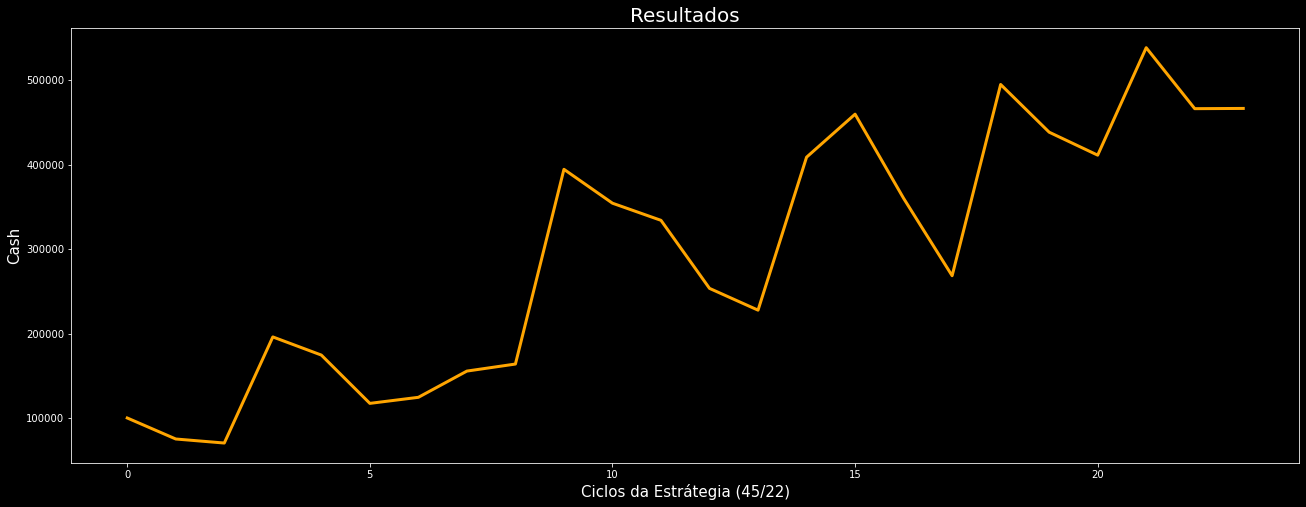

In [82]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="orange",linewidth=3)
plt.xlabel("Ciclos da Estrátegia (45/22)",fontsize=15)
plt.ylabel("Cash",fontsize=15)
plt.title("Resultados",fontsize=20)
plt.show

# Calculando o Sortino

In [107]:
ethereum["returns"]=ethereum["Adj Close"].pct_change()

In [108]:
cash_data2=pd.DataFrame(pd.Series(cash_data))
cash_data2=cash_data2.rename(columns={0:"Close"})

In [109]:
def sortino_ratio (series,N,rf):
    mean=series.mean()*N-rf
    std_neg=series[series<0].std()*np.sqrt(N)
    return mean/std_neg#

Sortino do Buy & Hold

In [110]:
sortino_buy_hold=sortino_ratio(ethereum["returns"],365,0)

Sortino do Modelo

In [112]:
cash_data2["returns"]=cash_data2["Close"].pct_change()
cash_data2=cash_data2.dropna()
sortino_estrategia=sortino_ratio(cash_data2["returns"],15.8695,0)

Calculando a Volatilidade do Buy & Hold de ETH-USD, logaritimizando os retornos para que a média da distribuição seja zero e não a média dos retornos percentuais do ativo

In [113]:
ethereum["Return"]=np.log(1+ethereum["Adj Close"].pct_change())
volatilidade_buy_hold=ethereum["Return"].std()*365**0.5 

In [121]:
volatilidade_estrategia=cash_data2["returns"][cash_data2["returns"]<0].std()*np.sqrt(365/23)

# Log de Resultados

In [123]:
resultado_buy_hold=(ethereum["Adj Close"].iloc[-1]-ethereum["Adj Close"].iloc[0])/ethereum["Adj Close"].iloc[0] *100
resultado_estrategia=(cash_data[-1]-cash_data[0])/cash_data[0]*100
print("Período: 04-06-2020 - 13/11/2021")
print("-="*20)
print(f"Retorno Buy & Hold no período: {resultado_buy_hold:.2f}%")
print(f"Retorno Estratégia no período: {resultado_estrategia:.2f}%")
print("-="*20)
print(f"Volatilidade Anual Buy & Hold: {volatilidade_buy_hold*100:.2f}% ")
print(f"Volatilidade Anual da Estratégia: {volatilidade_estrategia*100:.2f}% ")
print("-="*20)
retorno_anual_buy_hold=(((1+resultado_buy_hold/100)**(365/528)-1)*100)
retorno_anual_estrategia=((1+resultado_estrategia/100)**(365/528)-1)
print(f"Retorno Anual Buy & Hold: {((1+resultado_buy_hold/100)**(365/528)-1)*100:.2f}%")
print(f"Retorno Anual Estratégia: {((1+resultado_estrategia/100)**(365/528)-1)*100:.2f}%")
print("-="*20)
print(f"Sortino Buy & Hold: {sortino_buy_hold:.2f}")
print(f"Sortino Estratégia: {sortino_estrategia:.2f}")


Período: 04-06-2020 - 13/11/2021
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Retorno Buy & Hold no período: 1803.01%
Retorno Estratégia no período: 366.48%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Volatilidade Anual Buy & Hold: 98.17% 
Volatilidade Anual da Estratégia: 35.67% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Retorno Anual Buy & Hold: 666.41%
Retorno Anual Estratégia: 189.97%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Sortino Buy & Hold: 3.71
Sortino Estratégia: 6.96


A volatilidade da estratégia foi calculada pelo desvio padrão anualizado dos retornos negativos na estratégia e a logaritimização dos retornos no Buy & Hold. Além disso o Sortino é excelente, superando inclusive o Buy & Hold, que possui um ótimo valor. A estratégia pode ser montada em mercados altistas ou baixistas. No período analisado o ativo subiu muito, mas caso tivesse caído o Hedge da estratégia já estaria montado. desse modo demonstra-se a eficiência do modelo .

# Teste em BTC-USD

Vamos utilizar o mesmo passo a passo entretanto com base nos dados de Volatilidade implícita de BTC-USD e os preços do mesmo, já adiantando os resultados de ETH-USD foram melhores e por isso análise de gregas a posteriori e o modelo de predição direcional de volatilidade implícita será feito utilizando o ETH-USD. Entretanto BTC-USD também bateu o Buy & Hold em quesito retorno / risco

In [2]:
bitcoin_data=pd.read_excel("teste_volatilidade_bitcoin.xlsx")
bitcoin_data=bitcoin_data.set_index("Date")
bitcoin_data["IV"]=bitcoin_data["IV"].astype(float)
bitcoin_data

,IV,DTE
Date,,
2020-06-04 00:00:00,80.24,45
2020-06-05 00:00:00,80.15,44
2020-06-06 00:00:00,80.15,43
2020-06-07 00:00:00,80.15,42
2020-06-08 00:00:00,76.99,41
...,...,...
2021-11-09 00:00:00,88.38,26
2021-11-10 00:00:00,89.04,25
2021-11-11 00:00:00,89.11,24


In [3]:
bitcoin_data["IV%"]=bitcoin_data["IV"]/100
bitcoin_data=bitcoin_data.dropna()
bitcoin_data

,IV,DTE,IV%
Date,,,
2020-06-04 00:00:00,80.24,45,0.8024
2020-06-05 00:00:00,80.15,44,0.8015
2020-06-06 00:00:00,80.15,43,0.8015
2020-06-07 00:00:00,80.15,42,0.8015
2020-06-08 00:00:00,76.99,41,0.7699
...,...,...,...
2021-11-09 00:00:00,88.38,26,0.8838
2021-11-10 00:00:00,89.04,25,0.8904
2021-11-11 00:00:00,89.11,24,0.8911


In [5]:
bitcoin=pd.read_csv("precos_bitcoin.csv",sep=",")
bitcoin=bitcoin.set_index("Date")
bitcoin

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-04,9655.854492,9887.610352,9525.247070,9800.636719,9800.636719,25921805072
2020-06-05,9800.215820,9869.237305,9663.216797,9665.533203,9665.533203,23509628646
2020-06-06,9664.904297,9773.431641,9591.024414,9653.679688,9653.679688,20438419222
2020-06-07,9653.002930,9768.498047,9458.150391,9758.852539,9758.852539,25015250846
2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312
...,...,...,...,...,...,...
2021-11-09,67549.734375,68530.335938,66382.062500,66971.828125,66971.828125,42357991721
2021-11-10,66953.335938,68789.625000,63208.113281,64995.230469,64995.230469,48730828378
2021-11-11,64978.890625,65579.015625,64180.488281,64949.960938,64949.960938,35880633236


In [6]:
strike_list=[]
for x in range(len(bitcoin_data["IV"])):
    if bitcoin_data["DTE"].iloc[x]==45:     
        strike_list.append(bitcoin["Adj Close"].iloc[x])
        ultimo=bitcoin["Adj Close"].iloc[x]
    else:
        strike_list.append(ultimo)

In [7]:
strike_list=pd.DataFrame(pd.Series(strike_list))
strike_list=strike_list.rename(columns={0:"Strike"})
strike_list

,Strike
0,9800.636719
1,9800.636719
2,9800.636719
3,9800.636719
4,9800.636719
...,...
523,62210.171875
524,62210.171875
525,62210.171875
526,62210.171875


In [16]:
call_price=[]
put_price=[]
for a in range(len(bitcoin_data["IV"])):
    call_price.append(N(black_scholes_call.subs(S,bitcoin["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(bitcoin_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(bitcoin_data["IV"].iloc[a])/100).subs(r,0.05)))
    put_price.append(N(black_scholes_put.subs(S,bitcoin["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(bitcoin_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(bitcoin_data["IV"].iloc[a])/100).subs(r,0.05)))

In [17]:
call_price=pd.DataFrame(pd.Series(call_price))
put_price=pd.DataFrame(pd.Series(put_price))
options_prices=call_price

In [18]:
options_prices["Put"]=put_price
options_prices=options_prices.rename(columns={0:"Call"})
options_prices

,Call,Put
0,1124.94616095455,1064.71710529396
1,1036.13315753374,1112.34201168753
2,1016.93576861561,1106.33271438999
3,1061.70343486054,1047.26228908674
4,1014.70887473283,988.965952267132
...,...,...
523,8865.80877875298,3882.97616310884
524,7508.40606536080,4510.66333058308
525,7363.98874822223,4420.00893270909
526,7010.55274348829,4869.08701179727


In [19]:
call_delta=[]
put_delta=[]
for a in range(len(bitcoin_data["IV"])):
    call_delta.append(N(delta_call.subs(S,bitcoin["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(bitcoin_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(bitcoin_data["IV"].iloc[a])/100).subs(r,0.05)))
    put_delta.append(N(delta_put.subs(S,bitcoin["Adj Close"].iloc[a]).subs(K,strike_list["Strike"].iloc[a]).subs(T,float(bitcoin_data["DTE"].iloc[a])/365).subs(q,0).subs(v,float(bitcoin_data["IV"].iloc[a])/100).subs(r,0.05)))

In [20]:
call_delta=pd.DataFrame(pd.Series(call_delta))
put_delta=pd.DataFrame(pd.Series(put_delta))
options_prices["Call_Delta"]=call_delta
options_prices["Put_Delta"]=put_delta
options_prices.head()

,Call,Put,Call_Delta,Put_Delta
0,1124.94616095455,1064.71710529396,0.564642479820670,-0.435357520179330
1,1036.13315753374,1112.34201168753,0.544159448519977,-0.455840551480023
2,1016.93576861561,1106.33271438999,0.541432486552282,-0.458567513447718
3,1061.70343486054,1047.26228908674,0.556218369127648,-0.443781630872352
4,1014.70887473283,988.965952267132,0.555370195706793,-0.444629804293207


In [21]:
options_prices["Total_Delta"]=options_prices["Call_Delta"]*1+options_prices["Put_Delta"]*1
options_prices.head()

,Call,Put,Call_Delta,Put_Delta,Total_Delta
0,1124.94616095455,1064.71710529396,0.564642479820670,-0.435357520179330,0.129284959641340
1,1036.13315753374,1112.34201168753,0.544159448519977,-0.455840551480023,0.0883188970399547
2,1016.93576861561,1106.33271438999,0.541432486552282,-0.458567513447718,0.0828649731045644
3,1061.70343486054,1047.26228908674,0.556218369127648,-0.443781630872352,0.112436738255296
4,1014.70887473283,988.965952267132,0.555370195706793,-0.444629804293207,0.110740391413586


# Backtest em BTC-USD

In [23]:
cash=100000
Buy, Sell =[],[]
Buy_Ativo , Sell_Ativo =[],[]
cash_data_data=[]
df_log=pd.DataFrame()
df_log2=pd.DataFrame()
signal=0
amount=cash
cash_data=[cash]
trades=0
comission=0.005 # 0.5%
ativo_delta=0
btcusd=0
for i in range(len(bitcoin_data["IV"])):
    if bitcoin_data["DTE"].iloc[i]==45:
        comissao=comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])
        maximo=math.trunc(0.6*cash/(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]+comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])))
        cash-=maximo*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]+comission*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]))
        price=options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]
        a_row=pd.Series(["Buy",bitcoin.index[i],price,maximo,price*maximo,comissao])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True) 
        signal+=1     
    if bitcoin_data["DTE"].iloc[i]==22:
        cash+=maximo*(options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i])
        price=options_prices["Call"].iloc[i]+options_prices["Put"].iloc[i]
        a_row=pd.Series(["Sell",bitcoin.index[i],price,maximo,price*maximo,0])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True) 
        signal=0
    if options_prices["Total_Delta"].iloc[i]+ativo_delta>0: # + delta do ativo
        cash+=bitcoin["Adj Close"].iloc[i]*options_prices["Total_Delta"].iloc[i]
        price=bitcoin["Adj Close"].iloc[i]
        ativo_delta-=options_prices["Total_Delta"].iloc[i]
        a_row2=pd.Series(["Sell",bitcoin.index[i],price,options_prices["Total_Delta"].iloc[i],price*options_prices["Total_Delta"].iloc[i],0])
        row_df2=pd.DataFrame([a_row2])
        df_log2 = pd.concat([row_df2, df_log2], ignore_index=True) 
        btcusd+=options_prices["Total_Delta"].iloc[i]
    if options_prices["Total_Delta"].iloc[i]+ativo_delta<0:   
        cash-=bitcoin["Adj Close"].iloc[i]*options_prices["Total_Delta"].iloc[i]
        price=bitcoin["Adj Close"].iloc[i]
        ativo_delta+=options_prices["Total_Delta"].iloc[i]
        a_row2=pd.Series(["Buy",bitcoin.index[i],price,options_prices["Total_Delta"].iloc[i],price*options_prices["Total_Delta"].iloc[i],0])
        row_df2=pd.DataFrame([a_row2])
        df_log2 = pd.concat([row_df2, df_log2], ignore_index=True) 
        btcusd-=options_prices["Total_Delta"].iloc[i]
    if signal==0:
        cash_data.append(cash)

In [24]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2020-06-04,Buy,2189.66326624851,27,59120.9081887098,10.9483163312426
2020-06-27,Sell,1273.86959731823,27,34394.4791275923,0
2020-06-28,Buy,1646.29585600098,31,51035.1715360304,8.23147928000490
2020-07-21,Sell,1080.70236016422,31,33501.7731650909,0
2020-07-22,Buy,1515.66778373225,22,33344.6912421095,7.57833891866125
2020-08-14,Sell,2493.35011769265,22,54853.7025892383,0
2020-08-15,Buy,2734.66735589261,17,46489.3450501745,13.6733367794631
2020-09-07,Sell,2042.02931006415,17,34714.4982710906,0
2020-09-08,Buy,2218.76304590975,24,53250.3131018340,11.0938152295487


In [25]:
df_log2=df_log2[::-1]
df_log2=df_log2.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log2=df_log2.set_index("Date")
df_log2

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2020-06-04,Sell,9800.636719,0.129284959641340,1267.07492267535,0
2020-06-05,Buy,9665.533203,0.0883188970399547,853.649231792020,0
2020-06-06,Sell,9653.679688,0.0828649731045644,799.951907706199,0
2020-06-06,Buy,9653.679688,0.0828649731045644,799.951907706199,0
2020-06-07,Sell,9758.852539,0.112436738255296,1097.25354859957,0
...,...,...,...,...,...
2021-11-11,Buy,64949.960938,0.248948803811631,16169.2150831272,0
2021-11-12,Sell,64155.941406,0.206730919870137,13263.0167819970,0
2021-11-12,Buy,64155.941406,0.206730919870137,13263.0167819970,0


In [26]:
if df_log["Type"].iloc[-1]=="Buy":
    cash+=df_log["Total"].iloc[-1]
    df_log=df_log.iloc[:-1]
    Buy=Buy[:-1]

In [27]:
btcusd

0.0351145248179788

In [28]:
cash+=btcusd*bitcoin["Adj Close"].iloc[-1]
cash_data.append(cash_data[-1]+btcusd*bitcoin["Adj Close"].iloc[-1])

# Resultados da estrátegia em BTC-USD

<function matplotlib.pyplot.show(close=None, block=None)>

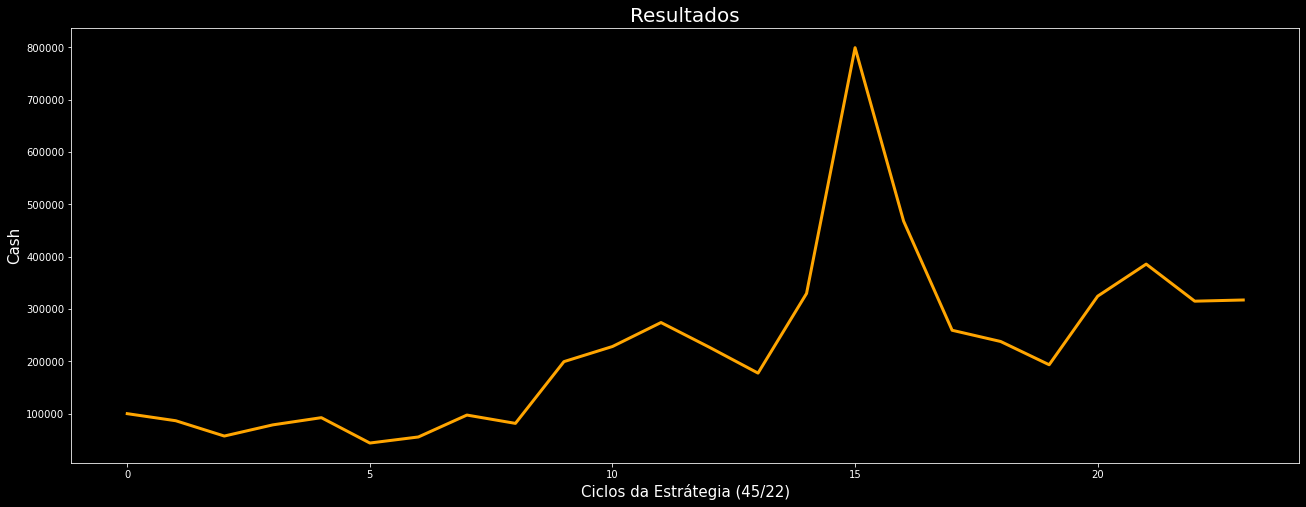

In [29]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="orange",linewidth=3)
plt.xlabel("Ciclos da Estrátegia (45/22)",fontsize=15)
plt.ylabel("Cash",fontsize=15)
plt.title("Resultados",fontsize=20)
plt.show

In [30]:
bitcoin["returns"]=bitcoin["Adj Close"].pct_change()

In [31]:
cash_data2=pd.DataFrame(pd.Series(cash_data))
cash_data2=cash_data2.rename(columns={0:"Close"})

In [32]:
def sortino_ratio (series,N,rf):
    mean=series.mean()*N-rf
    std_neg=series[series<0].std()*np.sqrt(N)
    return mean/std_neg#

In [34]:
sortino_buy_hold=sortino_ratio(bitcoin["returns"],365,0)

In [35]:
cash_data2["returns"]=cash_data2["Close"].pct_change()
cash_data2=cash_data2.dropna()
sortino_estrategia=sortino_ratio(cash_data2["returns"],15.8695,0)

In [36]:
bitcoin["Return"]=np.log(1+bitcoin["Adj Close"].pct_change())
volatilidade_buy_hold=bitcoin["Return"].std()*365**0.5 

In [37]:
volatilidade_estrategia=cash_data2["returns"][cash_data2["returns"]<0].std()*np.sqrt(365/23)

In [38]:
resultado_buy_hold=(bitcoin["Adj Close"].iloc[-1]-bitcoin["Adj Close"].iloc[0])/bitcoin["Adj Close"].iloc[0] *100
resultado_estrategia=(cash_data[-1]-cash_data[0])/cash_data[0]*100
print("Período: 04-06-2020 - 13/11/2021")
print("-="*20)
print(f"Retorno Buy & Hold no período: {resultado_buy_hold:.2f}%")
print(f"Retorno Estratégia no período: {resultado_estrategia:.2f}%")
print("-="*20)
print(f"Volatilidade Anual Buy & Hold: {volatilidade_buy_hold*100:.2f}% ")
print(f"Volatilidade Anual da Estratégia: {volatilidade_estrategia*100:.2f}% ")
print("-="*20)
retorno_anual_buy_hold=(((1+resultado_buy_hold/100)**(365/528)-1)*100)
retorno_anual_estrategia=((1+resultado_estrategia/100)**(365/528)-1)
print(f"Retorno Anual Buy & Hold: {((1+resultado_buy_hold/100)**(365/528)-1)*100:.2f}%")
print(f"Retorno Anual Estratégia: {((1+resultado_estrategia/100)**(365/528)-1)*100:.2f}%")
print("-="*20)
print(f"Sortino Buy & Hold: {sortino_buy_hold:.2f}")
print(f"Sortino Estratégia: {sortino_estrategia:.2f}")

Período: 04-06-2020 - 13/11/2021
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Retorno Buy & Hold no período: 557.81%
Retorno Estratégia no período: 217.18%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Volatilidade Anual Buy & Hold: 71.57% 
Volatilidade Anual da Estratégia: 57.95% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Retorno Anual Buy & Hold: 267.74%
Retorno Anual Estratégia: 122.10%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Sortino Buy & Hold: 3.19
Sortino Estratégia: 4.35


É de se perceber que novamente a relacão entre risco e retorno da estratégia superou o Buy & Hold, mas optaremos por manter ETH-USD como nosso modelo principal pela maior distorção entre o Sortino da estratégia para o Buy & Hold

# Visualizando as gregas da estrutura

# Setando os Parametros

Como exemplo colocamos que ETH-USD estava custando $ 244 (que seria o  valor em 04/06/2020 no nosso DataFrame, além de outros parâmetros arbitrários, cujo objetivo é somente compreender as gregas da estratégia)

### Call & Put; Spot Price = 244 ; Strike price = 244 ; Dividendos = 0%; Implied Volatility = 70%; Risk Free Rate: 5%; Days to Expiration 45

In [263]:
S_1=244 # Actual Spot Price
K_1=244 # Option Strike
DTE=45 # Days to Expiration 
q_1=0 # Stock Dividends
v_1=0.70# Implied Volatility in the Option Contract
r_1=0.05 # Risk Free Rate
days_year=365 # Days In the Year, BR:252, EUA:365
T_1=DTE/days_year

# Preço da Estrutura de exemplo

In [265]:
# Straddle Price with predetermined Parameters
N(black_scholes_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))+N(black_scholes_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))

47.5986941708189

A estrutura de compra de Call e compra de Put portanto estaria custando 47,59 doláres no exemplo

# Gregas de primeira ordem

##  Delta

$$
{\displaystyle \Delta ={\frac {\partial Black Scholes}{\partial S}}}
$$


O delta mensura a variação no preço das opções a partir do crescimento de $ 1.00 no preço do ativo (ETH-USD), na nossa estrátegia é a grega mais importante e objetivamos zerar o nosso delta, com o objetivo de não nos posicionarmos direcionalmente em ETH-USD. Portanto buscamos fazer o Delta Hedge

## Derivando Black & Scholes para encontrar o Delta

In [266]:
delta_call=diff(black_scholes_call,S)
delta_put=diff(black_scholes_put,S)
delta_call

-0.5*sqrt(2)*K*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) + (0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v)

In [267]:
delta_put

-0.5*sqrt(2)*K*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) + (0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) - 0.5)*exp(-T*q) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v)

### Valor do delta na estrutura montada

In [268]:
N(delta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)+delta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))

0.117636278923836

A estrutura se inicia com um delta extremamente baixo, próximo ao zero, o manejo da nossa posição realizado diariamente nos permite zerar o delta, no caso apresentado acima estamos levemente direcionais para a alta logo na montagem, portanto a cada 1 dolar que ETH-USD sobe a estrutura valoriza em 0.11

## Visualização do Delta

Text(0, 0.5, 'Delta')

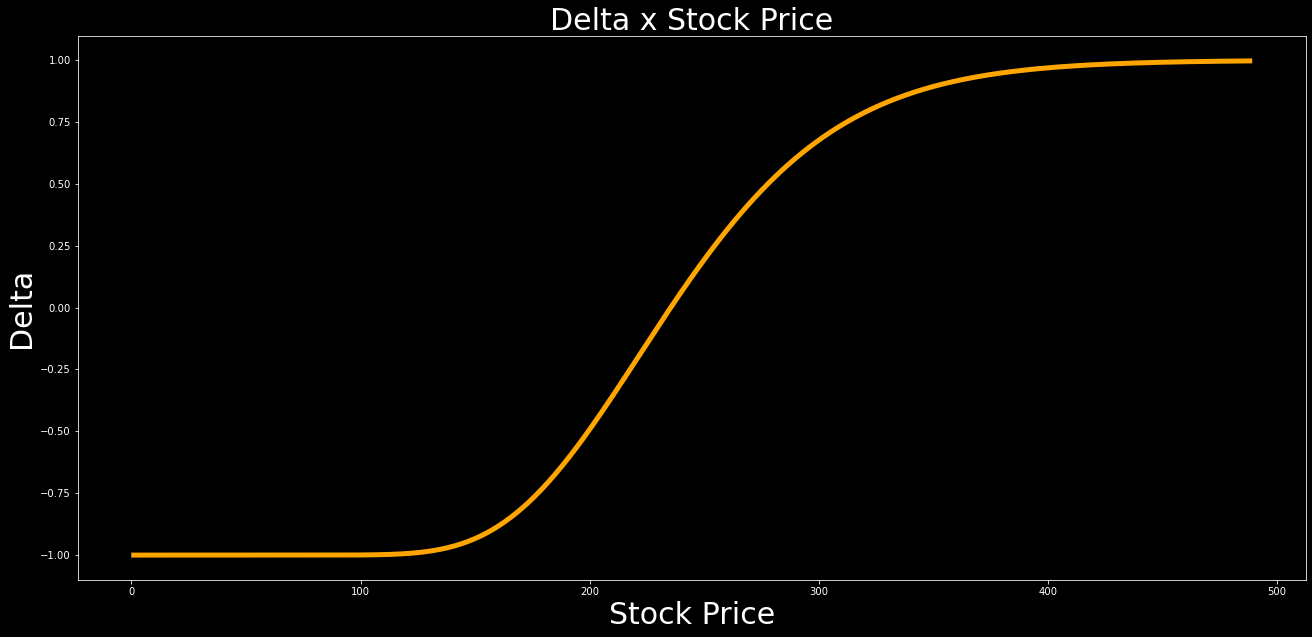

In [269]:
plt.figure(figsize=(22,10))
lista_delta=[]
for a in range(int(S_1*2)+1):
    x=(N(delta_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    y=(N(delta_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    lista_delta.append(x+y)
    df=pd.DataFrame(pd.Series(lista_delta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Delta x Stock Price",fontsize=30,color="white")
plt.xlabel("Stock Price",fontsize=30)
plt.ylabel("Delta",fontsize=30)


O gráfico acima demonstra algo bastante importante para a nossa estrátegia, a montagem da mesma é realizada no Stock Price = 244 portanto o nosso Delta está muito próximo do valor zero, conforme o ativo se desloca por exemplo para cima, o delta da estrutura vai subindo (tendendo ao valor $ 1.00), dessa maneira é necessário que se realize a venda do ativo em n quantidades, sendo n o valor do delta da estrutura, com isso o delta da nossa posição se zeraria e portanto estariamos não direcionais ao mercado

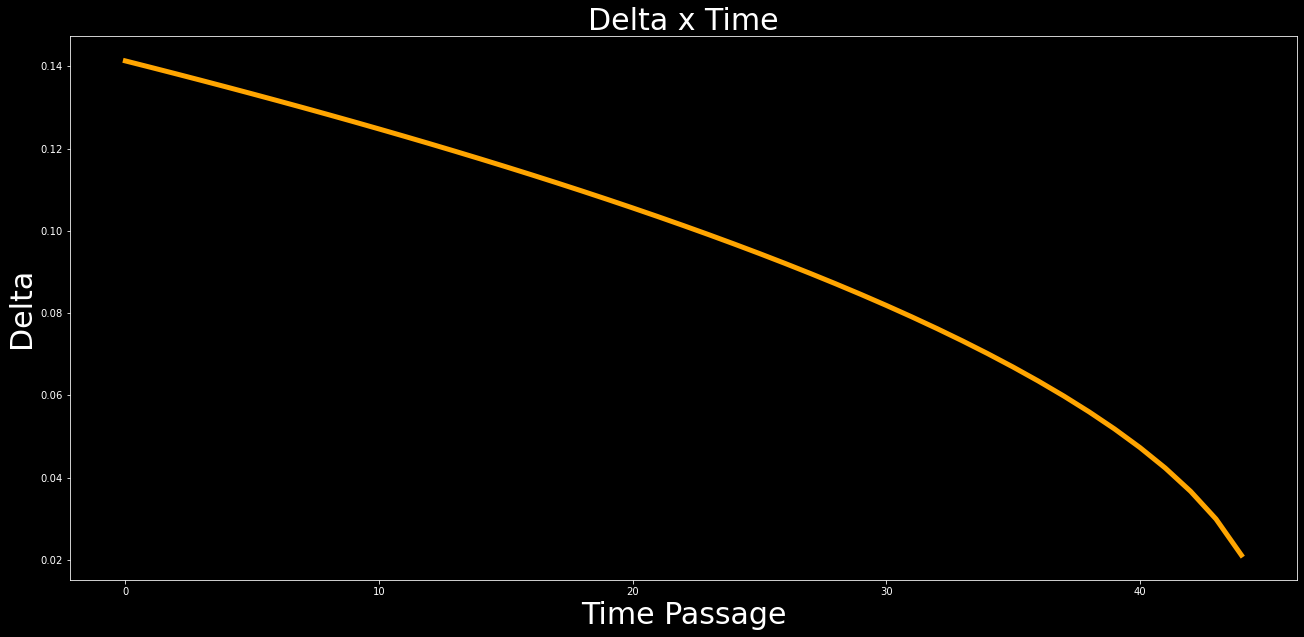

In [270]:
# the Charm effect
plt.figure(figsize=(22,10))
lista_delta=[]
for a in range(DTE):
    x=(N(delta_call.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/252).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    y=(N(delta_put.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/252).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    lista_delta.append(x+y)
df=pd.DataFrame(pd.Series(lista_delta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Delta x Time",fontsize=30,color="white")
plt.xlabel("Time Passage",fontsize=30)
plt.ylabel("Delta",fontsize=30)
plt.show()

O gráfico acima também é bastante interessante e explica bastante coisa de nossa estrutura, com a passagem do tempo existe o decaimento do nosso delta, tal decaimento consegue ser visualizado a partir da grega de segunda ordem Charm. Ou seja, não somente a variação do preço do ativo impacta no valor do delta mas também a passagem do tempo, por isso o balanceamento dinâmico de nossa estrutura se faz necessário diariamente. Considerando um caso em que o ativo fique estagnado em certo preço e os outros paramêtros se comportem da mesma maneira, restando apenas o tempo como váriavel, é possível identificar que o delta iria naturalmente se aproximando do zero, e portanto o manejo seria alterado

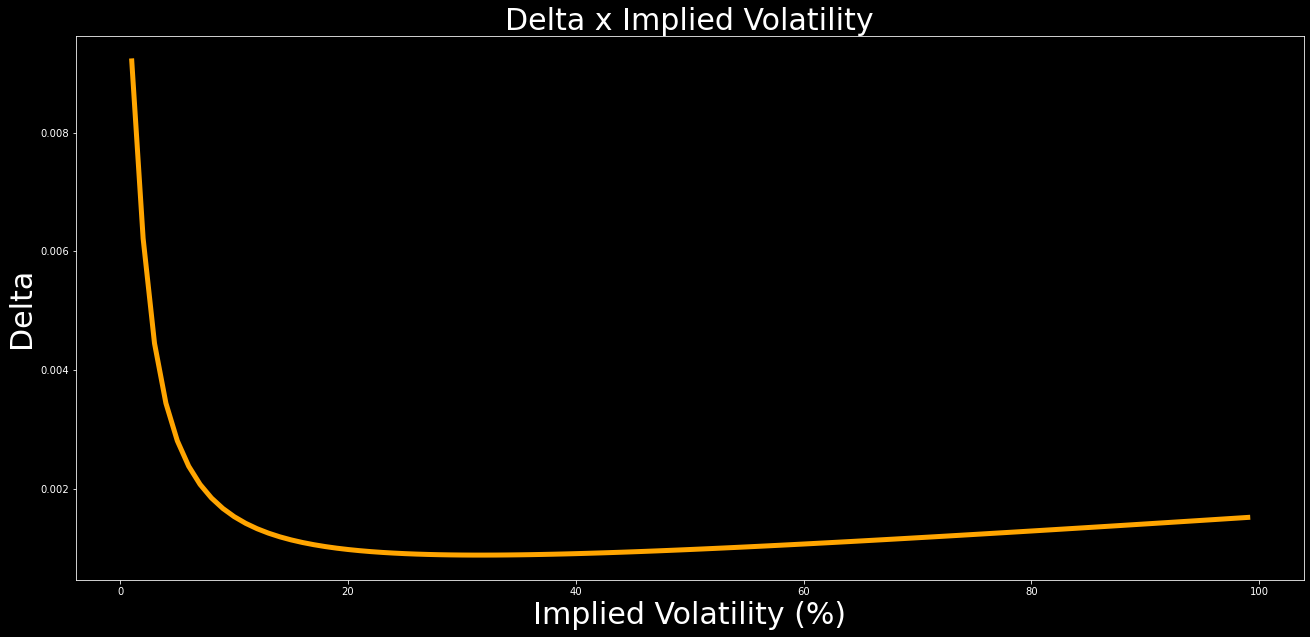

In [271]:
# the Vanna effect
plt.figure(figsize=(22,10))
lista_delta=[]
for a in range(100):
    x=(N(delta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    y=(N(delta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    lista_delta.append(x+y)
df=pd.DataFrame(pd.Series(lista_delta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Delta x Implied Volatility",fontsize=30,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=30)
plt.ylabel("Delta",fontsize=30)
plt.show()
# + Implied Volatility = - Delta

O gráfico acima também pode ser visualizado a partir da grega de segunda ordem Vanna, e exemplifica como que o delta varia a partir da variação da volatilidade implícita das opções, dessa forma uma variação na volatilidade implícita faz com que seja necessário o manejo da posição, reforça-se novamente a importância do balanceamento dinâmico

Text(0, 0.5, 'Delta')

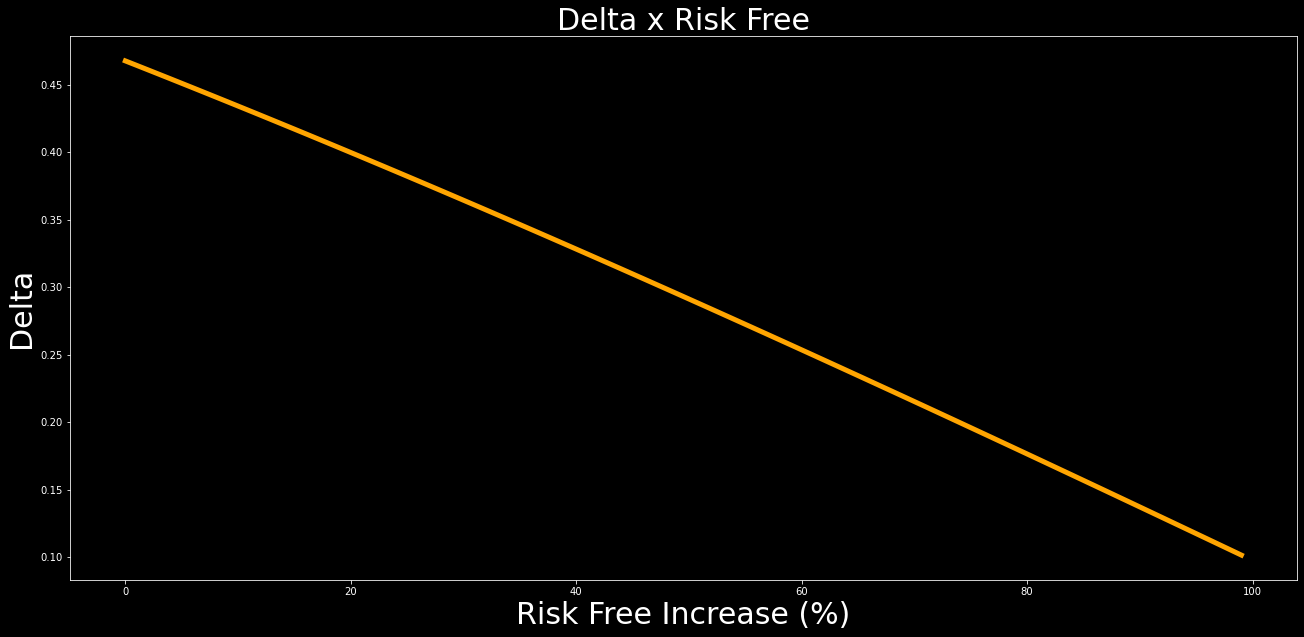

In [272]:
plt.figure(figsize=(22,10))
lista_delta=[]
for a in range(100):
    x=(N(delta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))))
    y=(N(delta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))))
    lista_delta.append(x+y)
df=pd.DataFrame(pd.Series(lista_delta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Delta x Risk Free",fontsize=30,color="white")
plt.xlabel("Risk Free Increase (%)",fontsize=30)
plt.ylabel("Delta",fontsize=30)
# higher risk free = higher delta, but this variation is not so relevant, delta decays a litlle bit 

Talvez a variavél menos relevante mas que optamos por colocar aqui seja como a taxa de juros livre de risco impacta do delta, percebe-se que a variação do eixo y (Delta) é mínima em relação a uma variação até mesmo irreal na taxa de juros, de qualquer forma é interessante notar que a subida de taxa de juros é um dos componentes que permite o decaimento do delta, dessa forma o mesmo tenderia a se aproximar do valor zero

## Theta

$$
{\displaystyle \Theta =-{\frac {\partial Black Scholes}{\partial T }}}
$$


O theta indica qual valor financeiro que nossa estrutura de Straddle será desvalorizado a cada passagem de um dia, portanto a passagem do tempo (considerando que o ativo fique estagnado em relação a preço) é algo negativo para nossa estrutura, e o theta mede justamente esse impacto, é necessário colocar o sinal de negativo antes da derivação visto que a derivada se importaria apenas com o acrescimo de Tempo e sabe-se que os dias para o vencimento do contrato apenas decai com cada tempo passado 

## Derivando Black & Scholes para encontrar o Theta

In [273]:
theta_call=-diff(black_scholes_call,T)
theta_put=-diff(black_scholes_put,T)
theta_call.simplify()
# ERF = Cumulative Probability Density Function

K*r*(0.5*erf(sqrt(2)*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))/2) - 0.5)*exp(-T*r) - 0.5*sqrt(2)*K*(v/(2*sqrt(T)) - (-q + r + 0.5*v**2)/(sqrt(T)*v) + (T*(-q + r + 0.5*v**2) + log(S/K))/(2*T**(3/2)*v))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/sqrt(pi) + S*q*(0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q) - 1.0*S*(sqrt(2)*(-q + r + 0.5*v**2)/(2*sqrt(T)*v) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(4*T**(3/2)*v))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi)

In [274]:
theta_put

K*r*(0.5*erf(sqrt(2)*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))/2) + 0.5)*exp(-T*r) - 0.5*sqrt(2)*K*(v/(2*sqrt(T)) - (-q + r + 0.5*v**2)/(sqrt(T)*v) + (T*(-q + r + 0.5*v**2) + log(S/K))/(2*T**(3/2)*v))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/sqrt(pi) - S*q*(0.5 - 0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)))*exp(-T*q) - 1.0*S*(sqrt(2)*(-q + r + 0.5*v**2)/(2*sqrt(T)*v) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(4*T**(3/2)*v))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi)

## Valor do Theta da estrutura

é necessário dividir o valor do theta pelo número de dias no ano, para visualizar o impacto da variação de um dia no preço da estrutura.

In [275]:
# Example of Usage
N(theta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/days_year+N(theta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year)

-0.523296308124223

Para cada dia passado 52 centavos da estrutura são perdidos, vale ressaltar que o próprio theta varia com a passagem do tempo como veremos mais adiante, e essa é justamente a explicação pelo qual optamos por montar a estrutura com 45 dias para o vencimento e desmontar com 22 dias para o mesmo

## Visualização do Theta

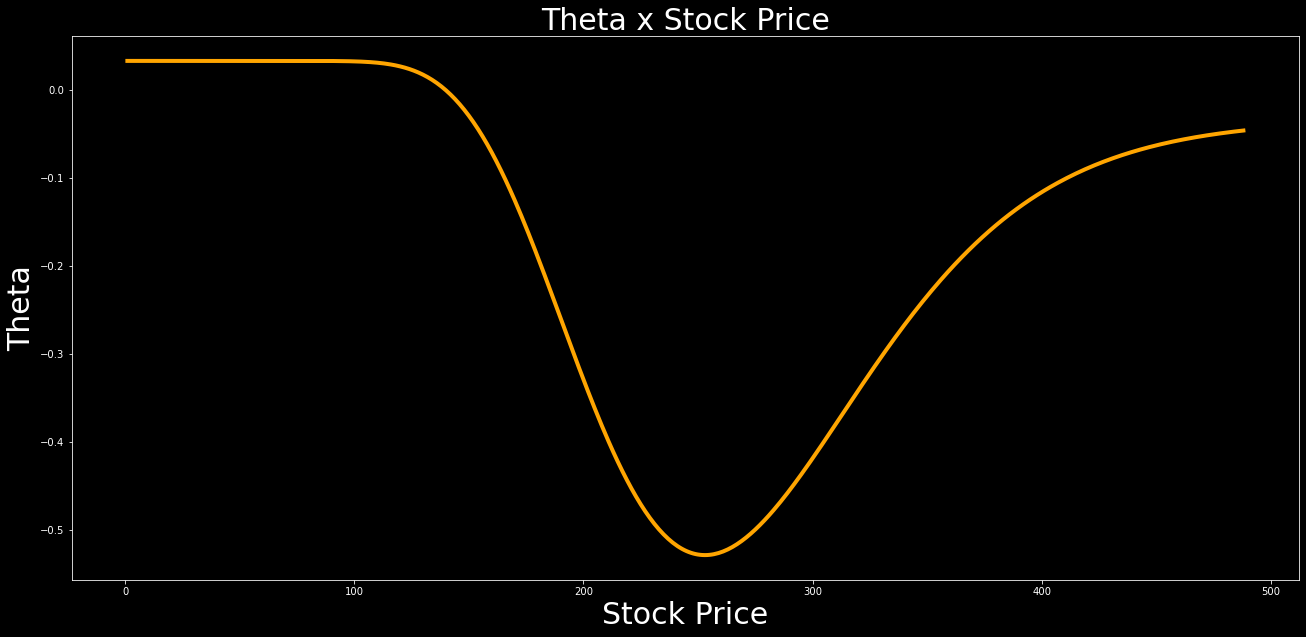

In [277]:
plt.figure(figsize=(22,10))
lista_theta=[]
for a in range(int(S_1*2)+1):
    x=(N(theta_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year))
    y=(N(theta_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year))
    lista_theta.append(x+y)
df=pd.DataFrame(pd.Series(lista_theta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Theta x Stock Price",fontsize=30,color="white")
plt.xlabel("Stock Price",fontsize=30)
plt.ylabel("Theta",fontsize=30)
plt.show()

Esse gráfico acima é bastante interessante pois reflete o principal risco da operação (o ativo estagnar no preço de 244), visto que a perda financeira é maximizada justamente nesse ponto, esse é o principal argumento para justificar a importância de montar estruturas de Straddles em ativos voláteis

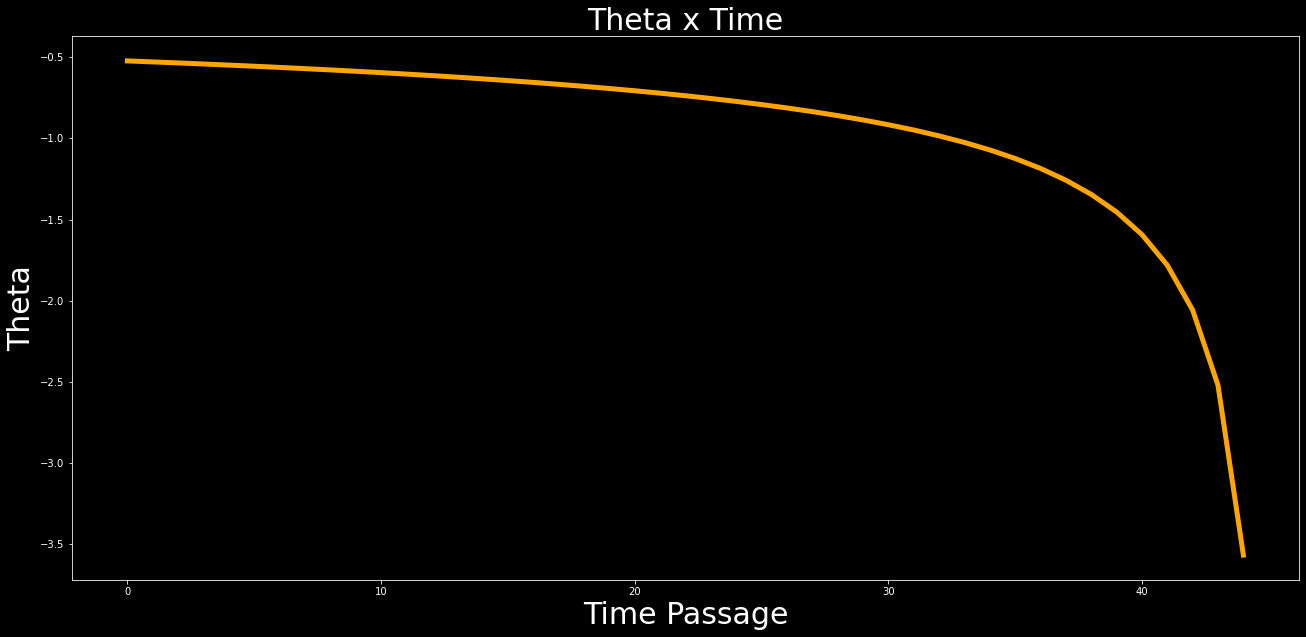

In [278]:
# New Greek --> Tau, theta per time
plt.figure(figsize=(22,10))
lista_theta=[]
for a in range(DTE):
    x=(N(theta_call.subs(S,S_1).subs(K,K_1).subs(T,(T_1*days_year-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year))
    y=(N(theta_put.subs(S,S_1).subs(K,K_1).subs(T,(T_1*days_year-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year))
    lista_theta.append(x+y)
df=pd.DataFrame(pd.Series(lista_theta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Theta x Time",fontsize=30,color="white")
plt.xlabel("Time Passage",fontsize=30)
plt.ylabel("Theta",fontsize=30)
plt.show()

o gráfico acima é o principal motivo pelo qual se escolheu montar essa estrátegia com 45 dias para o vencimento e desmontar a estrutura com 22 dias para o vencimento, conforme o tempo passa o theta da estrutura vai ficando mais negativo, ou seja para cada passagem de dia a próxima passagem de tempo impacta em uma perda financeira maior na estrutura, dessa forma caso montassemos a estrutura em um prazo próximo ao vencimento dos contratos a perda financeira diaria seria bastante alta, além disso as opções com 45 dias possuem uma boa liquidez e volume de negociações tanto na deribit quanto na FTX

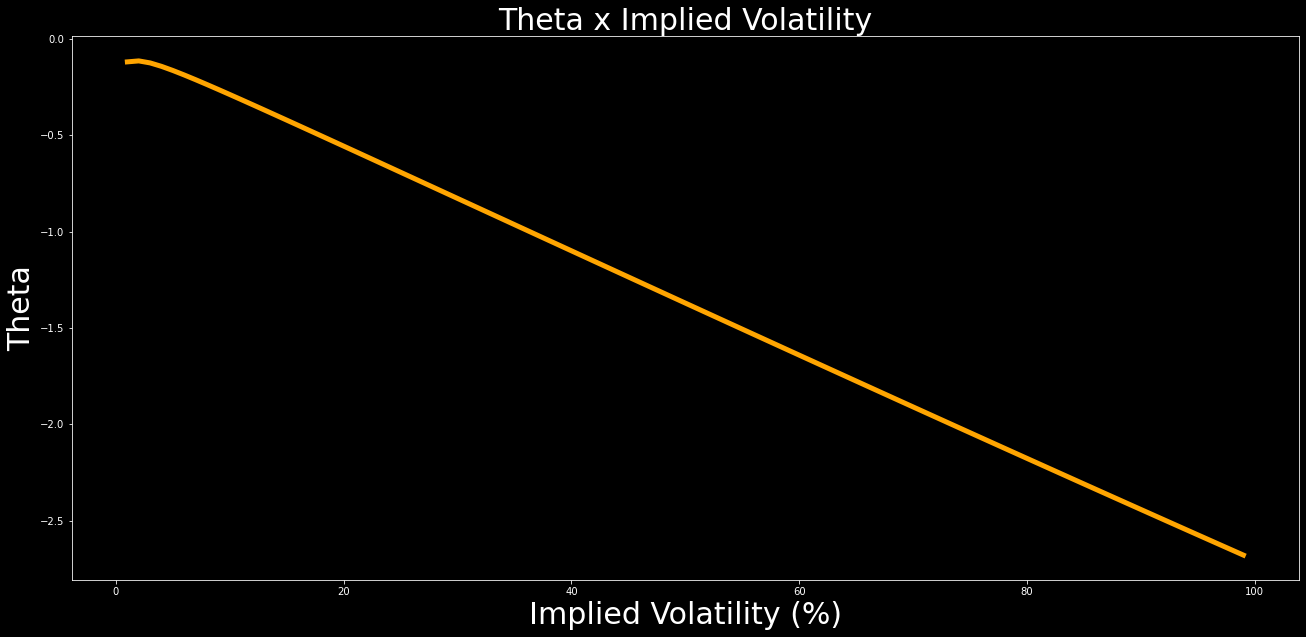

In [279]:
# the Veta effect
plt.figure(figsize=(22,10))
lista_theta=[]
for a in range(100):
    x=(N(theta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    y=(N(theta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    lista_theta.append(x+y)
df=pd.DataFrame(pd.Series(lista_theta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Theta x Implied Volatility",fontsize=30,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=30)
plt.ylabel("Theta",fontsize=30)
plt.show()
# + Implied Volatility = - Theta
# Vega and Theta decre

O gráfico acima demonstra como o Theta decai a partir do crescimento da volatilidade implícita, entranto o theta pode corroer menos os ganhos da estrutura caso ocorra uma queda na volatilidade implícita, em contrapartida a nossa estrutura prefere subidas de volatilidade do que quedas, haja em vista que mais para frente do código apresentaremos o vega

Text(0, 0.5, 'Theta')

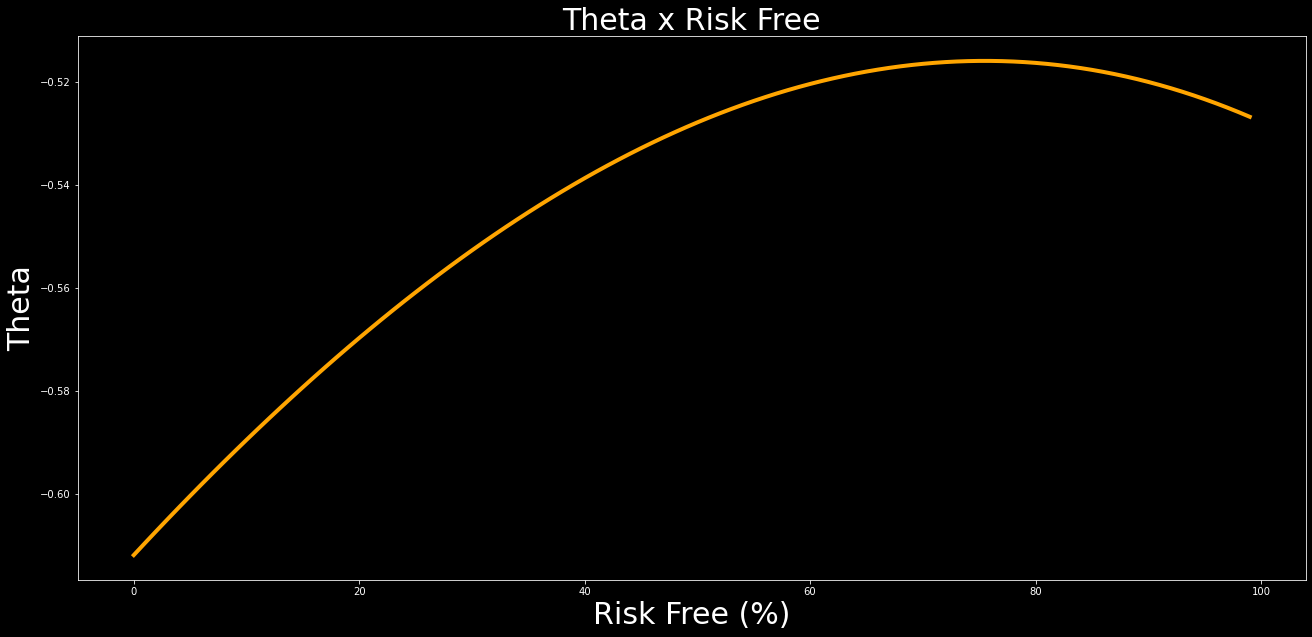

In [280]:
# New Greek but not so relevant
plt.figure(figsize=(22,10))
lista_theta=[]
for a in range(100):
    x=(N(theta_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))/days_year))
    y=(N(theta_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))/days_year))
    lista_theta.append(x+y)
df=pd.DataFrame(pd.Series(lista_theta))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Theta x Risk Free",fontsize=30,color="white")
plt.xlabel("Risk Free (%)",fontsize=30)
plt.ylabel("Theta",fontsize=30)
# theta is directly proportional to the risk free rate!, but it can't change the signal
# not so relevant changes

A subida de taxa de juros varia, ainda que minimamente nosso theta, fazendo com que ocorra uma perda financeira menor a cada passagem de dia por meio da subida da Risk Free

## Vega

 $$
{\displaystyle {\mathcal {V}}={\frac {\partial Black Scholes}{\partial \sigma }}}
$$

Vega representa a variação no preço de nossa estrutura a partir da subida de 1% na volatilidade implícita

## Derivando Black & Scholes para encontrar o Vega

In [23]:
vega_call=diff(black_scholes_call,v)
vega_put=diff(black_scholes_put,v)
vega_call

0.5*sqrt(2)*K*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*sqrt(T)*v**2) + 1.0*S*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v**2))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi)

In [24]:
vega_put

0.5*sqrt(2)*K*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*sqrt(T)*v**2) + 1.0*S*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v**2))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi)

##  Valor do Vega
Precisamos dividir por 100 para visualizar a variação do preço do Straddle em relação a subida de 1%

In [281]:
N(vega_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100+N(vega_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100

0.676137503381254

A cada 1% de subida de volatilidade implícita o Straddle varia em 67 centavos, bom ressaltar que o próprio vega varia a partir de outros paramêtros, como volatilidade, tempo , preço do ativo e outros, veremos nos gráficos abaixo o impacto das variaveis

## Vega Graphs

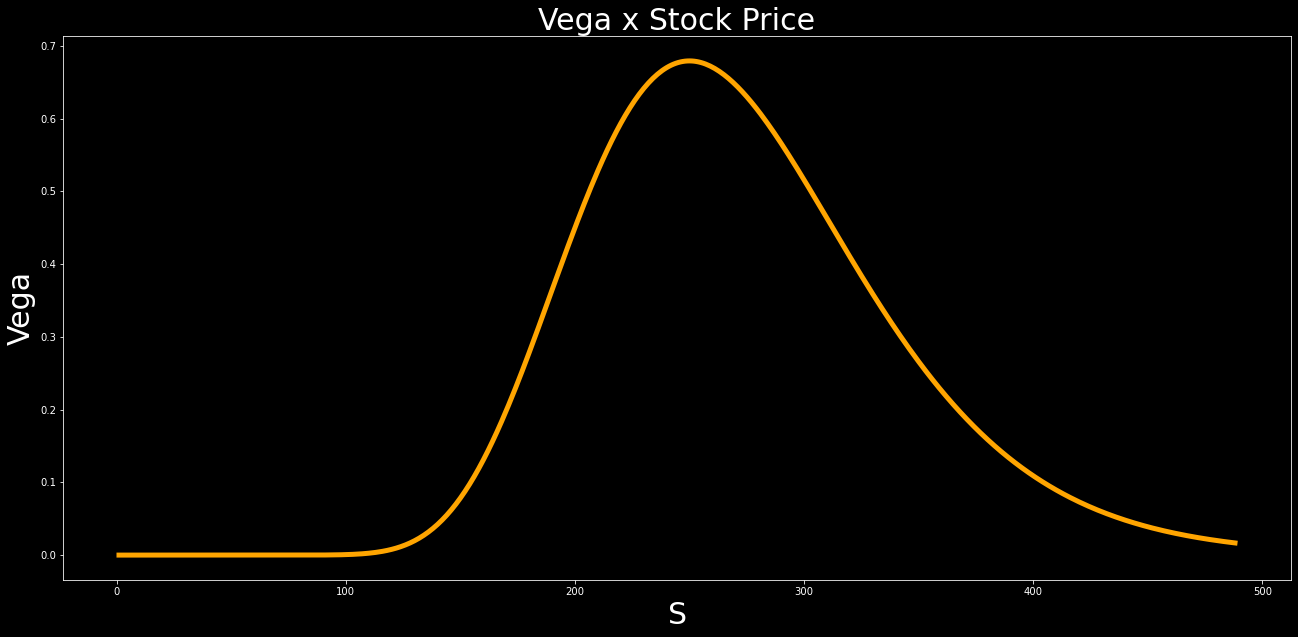

In [282]:
# The Vanna effect
plt.figure(figsize=(22,10))
lista_vega=[]
for a in range(int(S_1*2)+1):
    x=(N(vega_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/100))
    y=(N(vega_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/100))
    lista_vega.append(x+y)
df=pd.DataFrame(pd.Series(lista_vega))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Vega x Stock Price",fontsize=30,color="white")
plt.xlabel("S",fontsize=30)
plt.ylabel("Vega",fontsize=30)
plt.show()

O gráfico acima é o oposto do Theta / Stock Price, visto que seu ponto de máximo ocorre no valor de Stock Price = 244 contrapondo com o Theta, que possui a PERDA máxima justamente nesse ponto.

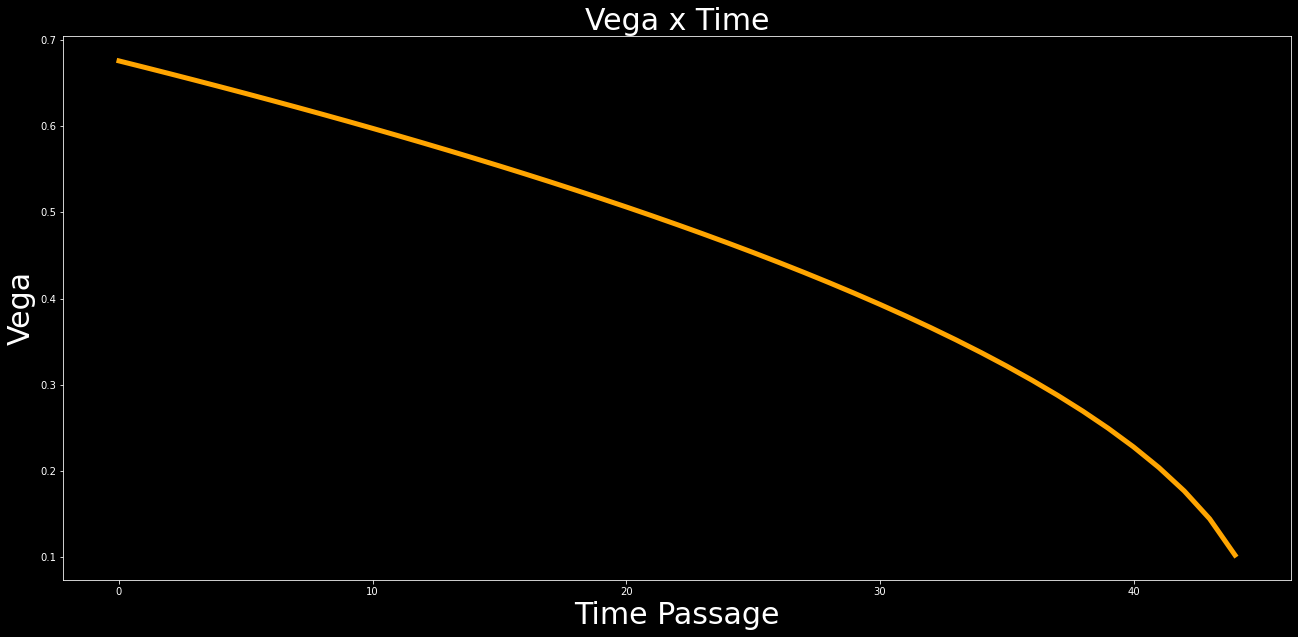

In [283]:
# the Veta Effect
plt.figure(figsize=(22,10))
lista_vega=[]
for a in range(DTE):
    x=(N(vega_call.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1)/100))
    y=(N(vega_put.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1)/100))
    lista_vega.append(x+y)
df=pd.DataFrame(pd.Series(lista_vega))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Vega x Time",fontsize=30,color="white")
plt.xlabel("Time Passage",fontsize=30)
plt.ylabel("Vega",fontsize=30)
plt.show()
# + time passage = - vega

Com a passagem do tempo o vega vai decaindo, ou seja a cada subida de 1% na volatilidade implícita o preço do straddle aumenta menos se for nos dias finais do contrato, outro argumento pelo qual a montagem da estrutura não deve ser feita em dias próximos ao vencimento caso se possua uma tendência de subida de volatilidade implícita

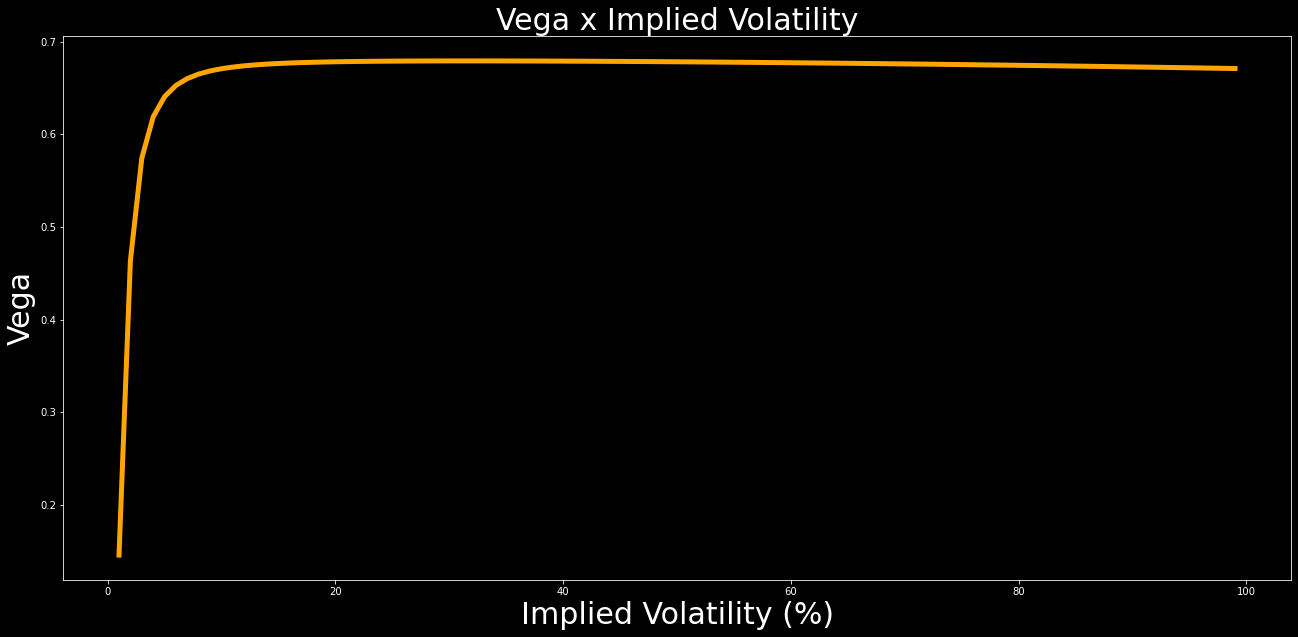

In [284]:
# the Vomma effect
plt.figure(figsize=(22,10))
lista_vega=[]
for a in range(100):
    x=(N(vega_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    y=(N(vega_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    lista_vega.append(x+y)
df=pd.DataFrame(pd.Series(lista_vega))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Vega x Implied Volatility",fontsize=30,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=30)
plt.ylabel("Vega",fontsize=30)
plt.show()
# + Implied Volatility = +Vega

A subida de volatilidade implícita faz com que o vega fique cada vez mais positivo, por meio da grega de segunda ordem Vomma é possivel identificar essa dinâmica.

Text(0, 0.5, 'Vega')

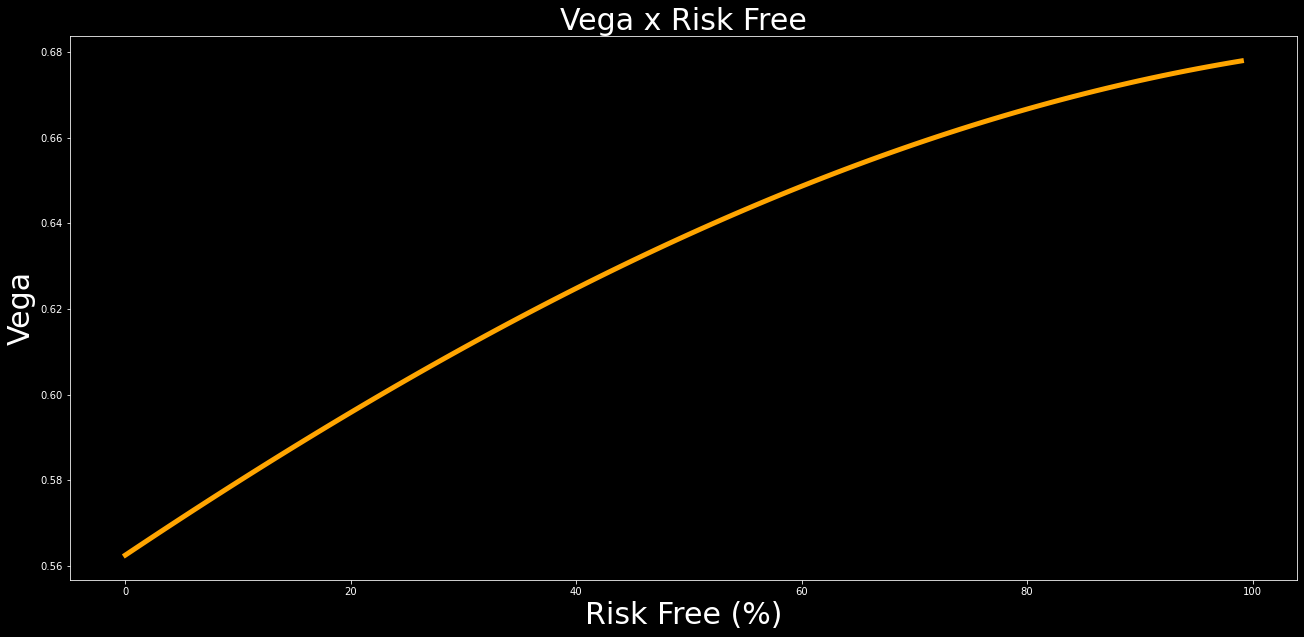

In [285]:
# New greek but not so relevant
plt.figure(figsize=(22,10))
lista_vega=[]
for a in range(100):
    x=(N(vega_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))/100))
    y=(N(vega_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))/100))
    lista_vega.append(x+y)
df=pd.DataFrame(pd.Series(lista_vega))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Vega x Risk Free",fontsize=30,color="white")
plt.xlabel("Risk Free (%)",fontsize=30)
plt.ylabel("Vega",fontsize=30)
# vega is directly proportional to the risk free rate!, but it can't change the signal
# not so relevant changes, but more relevant in vega than in theta...

A subida de taxa de juros faz com que o Vega fique cada vez mais positivo, entretanto esse valor não é relevante

# Second Order Greeks

## Gamma

$$
{\displaystyle \Gamma ={\frac {\partial \Delta }{\partial S}}={\frac {\partial ^{2}Black Scholes}{\partial S^{2}}}}
$$

O gamma é uma das principais gregas e origina o nome de nossa estrátegia , ele mede a variação do Delta ao se variar o preço do ativo, dessa forma com a movimentação natural do ativo se faz necessario o rebalanceamento do delta para assim se manter zerado nessa grega, e portanto não se posicionar direcionalmente ao mercado.

## Derivando Black &  Scholes para encontrar o Gamma

In [286]:
gamma_call=black_scholes_call.diff(S).diff(S)
gamma_put=black_scholes_put.diff(S).diff(S)
gamma_call

0.5*sqrt(2)*K*(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S**2*T*v**2) + 0.5*sqrt(2)*K*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S**2*sqrt(T)*v) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*S*sqrt(T)*v) - 0.5*sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*S*T**(3/2)*v**3)

In [287]:
gamma_put

-0.5*sqrt(2)*K*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S**2*T*v**2) + 0.5*sqrt(2)*K*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S**2*sqrt(T)*v) + 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*S*sqrt(T)*v) - 0.5*sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*S*T**(3/2)*v**3)

## Valor do Gamma

In [288]:
# Example of Usage
N(gamma_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)+gamma_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))

0.0131594483441342

Para cada subida de 1 no preço de ETH-USD o delta varia em 0.013

## Visualização do Gamma

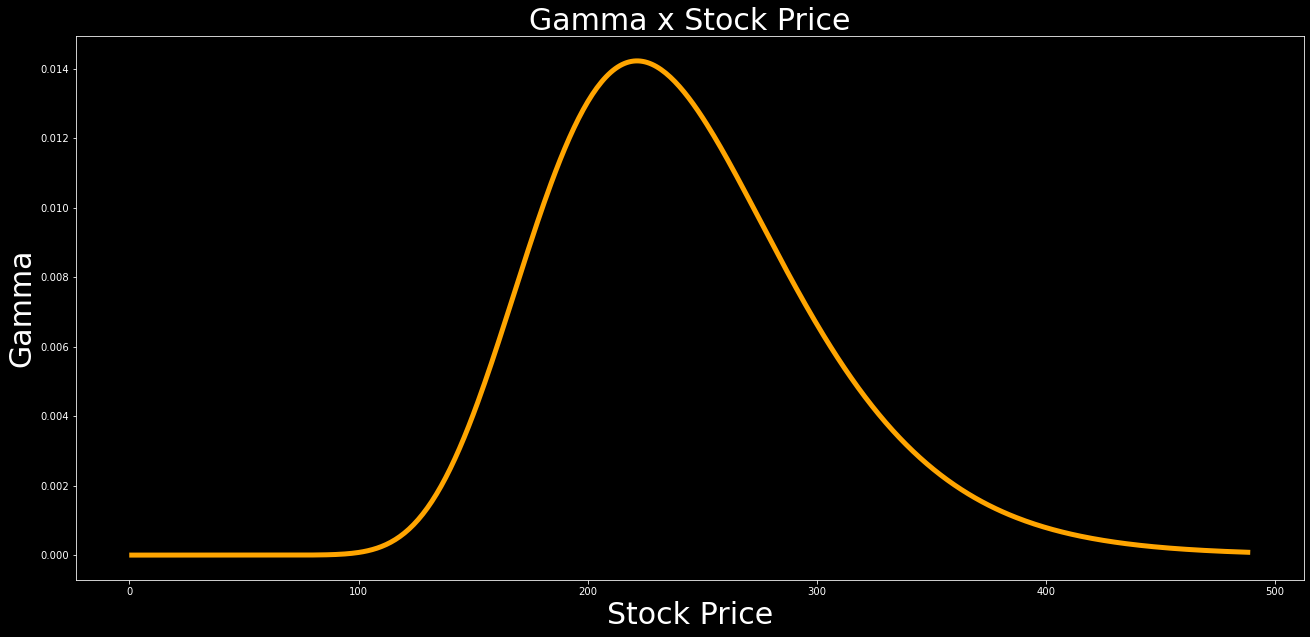

In [289]:
# The speed effect
plt.figure(figsize=(22,10))
lista_gamma=[]
for a in range(int(S_1*2)+1):
    x=(N(gamma_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    y=(N(gamma_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)))
    lista_gamma.append(x+y)
df=pd.DataFrame(pd.Series(lista_gamma))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=5)
plt.title("Gamma x Stock Price",fontsize=30,color="white")
plt.xlabel("Stock Price", fontsize=30)
plt.ylabel("Gamma",fontsize=30)
plt.show()

O gráfico acima demonstra que o ponto de maximização do gamma ocorre quando o Stock Price está em 244 portanto no At the Money.

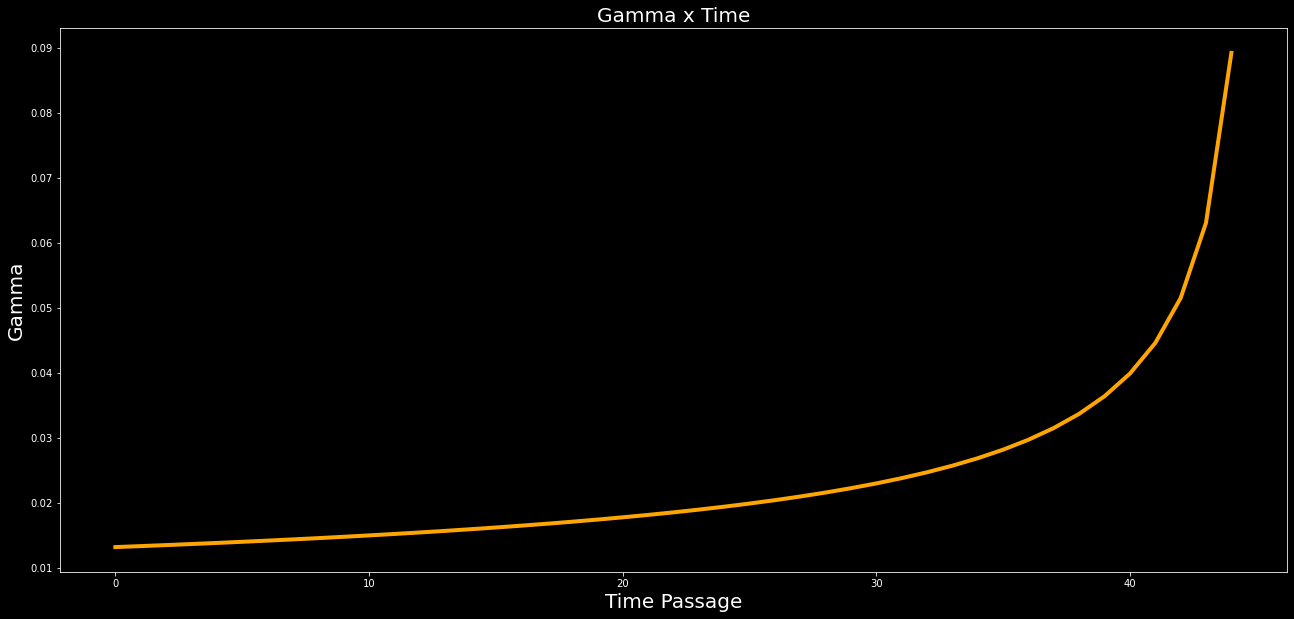

In [290]:
# The Color Effect
plt.figure(figsize=(22,10))
lista_gamma=[]
for a in range(DTE):
    x=N(gamma_call.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))
    y=N(gamma_put.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))
    lista_gamma.append(x+y)
df=pd.DataFrame(pd.Series(lista_gamma))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Gamma x Time",fontsize=20,color="white")
plt.xlabel("Time Passage",fontsize=20)
plt.ylabel("Gamma",fontsize=20)
plt.show()

O gamma é bastante explosivo nos dias próximos ao vencimento, operacionalmente é bom evitar movimentos explosivos, reforçando assim a necessidade de se evitar operar o Straddle próximo do vencimento das opções

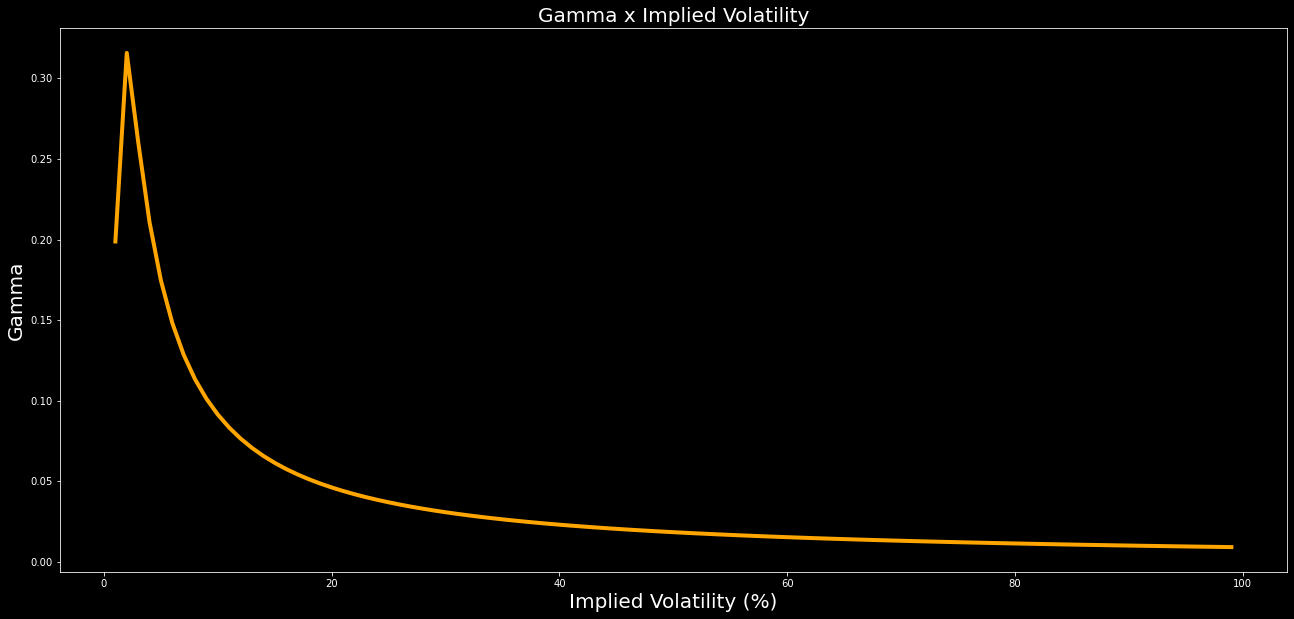

In [292]:
# The Zomma effect
plt.figure(figsize=(22,10))
lista_gamma=[]
for a in range(100):
    x=N(gamma_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))
    y=N(gamma_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))
    lista_gamma.append(x+y)
df=pd.DataFrame(pd.Series(lista_gamma))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Gamma x Implied Volatility",fontsize=20,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=20)
plt.ylabel("Gamma",fontsize=20)
plt.show()

O gráfico acima representa a variação do gamma a partir da subida de volatilidade implícita

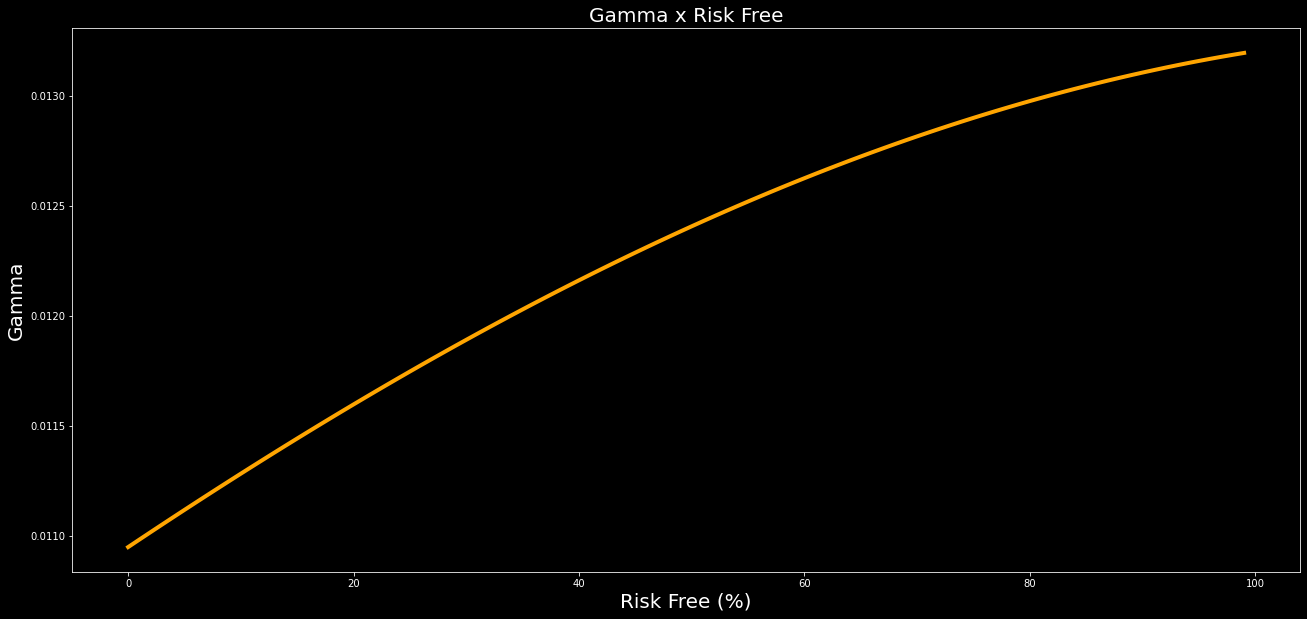

In [293]:
# New greek but not so relevant changes in Gamma
plt.figure(figsize=(22,10))
lista_gamma=[]
for a in range(100):
    x=(N(gamma_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))))
    y=(N(gamma_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100))))
    lista_gamma.append(x+y)
df=pd.DataFrame(pd.Series(lista_gamma))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Gamma x Risk Free",fontsize=20,color="white")
plt.xlabel("Risk Free (%)",fontsize=20)
plt.ylabel("Gamma",fontsize=20)
plt.show()

A subida de taxa de juros impacta (minimamente) o valor do Gamma

## Charm

$$
{\displaystyle {\text{Charm}}=-{\frac {\partial \Delta }{\partial T }}={\frac {\partial \Theta }{\partial S}}=-{\frac {\partial ^{2}Black Scholes}{\partial T \,\partial S}}}
$$

O charm mensura a variação do Delta a partir da passagem do tempo, dessa forma é possivel entender como o hedge devera ser efetuado nos próximos dias

## Derivando Black & Scholes para encontrar o Charm

In [297]:
charm_call=-black_scholes_call.diff(S).diff(T)
charm_put=-black_scholes_put.diff(S).diff(T)
charm_call

-0.5*sqrt(2)*K*r*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) - 0.25*sqrt(2)*K*(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*(-v/sqrt(T) + 2*(-q + r + 0.5*v**2)/(sqrt(T)*v) - (T*(-q + r + 0.5*v**2) + log(S/K))/(T**(3/2)*v))*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) - 0.25*sqrt(2)*K*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*T**(3/2)*v) + q*(0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q) - 1.0*(sqrt(2)*(-q + r + 0.5*v**2)/(2*sqrt(T)*v) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(4*T**(3/2)*v))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi) + 0.5*sqrt(2)*q*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v) - 0.5*sqrt(2)*(-(T*(-q + r + 0.5*v**2) + log(S/K))*(-2*q + 2*r + v**2)/(2*T*v**2) + (T*(-q + r 

In [298]:
charm_put

-0.5*sqrt(2)*K*r*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) - 0.25*sqrt(2)*K*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*(v/sqrt(T) - 2*(-q + r + 0.5*v**2)/(sqrt(T)*v) + (T*(-q + r + 0.5*v**2) + log(S/K))/(T**(3/2)*v))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v) - 0.25*sqrt(2)*K*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*T**(3/2)*v) + q*(0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) - 0.5)*exp(-T*q) - 1.0*(sqrt(2)*(-q + r + 0.5*v**2)/(2*sqrt(T)*v) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(4*T**(3/2)*v))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi) + 0.5*sqrt(2)*q*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v) - 0.5*sqrt(2)*(-(T*(-q + r + 0.5*v**2) + log(S/K))*(-2*q + 2*r + v**2)/(2*T*v**2) + (T*(-q + r + 0.5

## Valor do Charm do Straddle

Necessitamos dividir pelo número de dias para visualizar o impacto da passagem de 1 dia

In [299]:
N(charm_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year)+N(charm_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1)/days_year)

-0.00129755766001476

Para cada dia passado o delta decai em 0,00129, esse valor ajuda a entender o gráfico delta / tempo demonstrado anteriormente

## Visualização do Charm

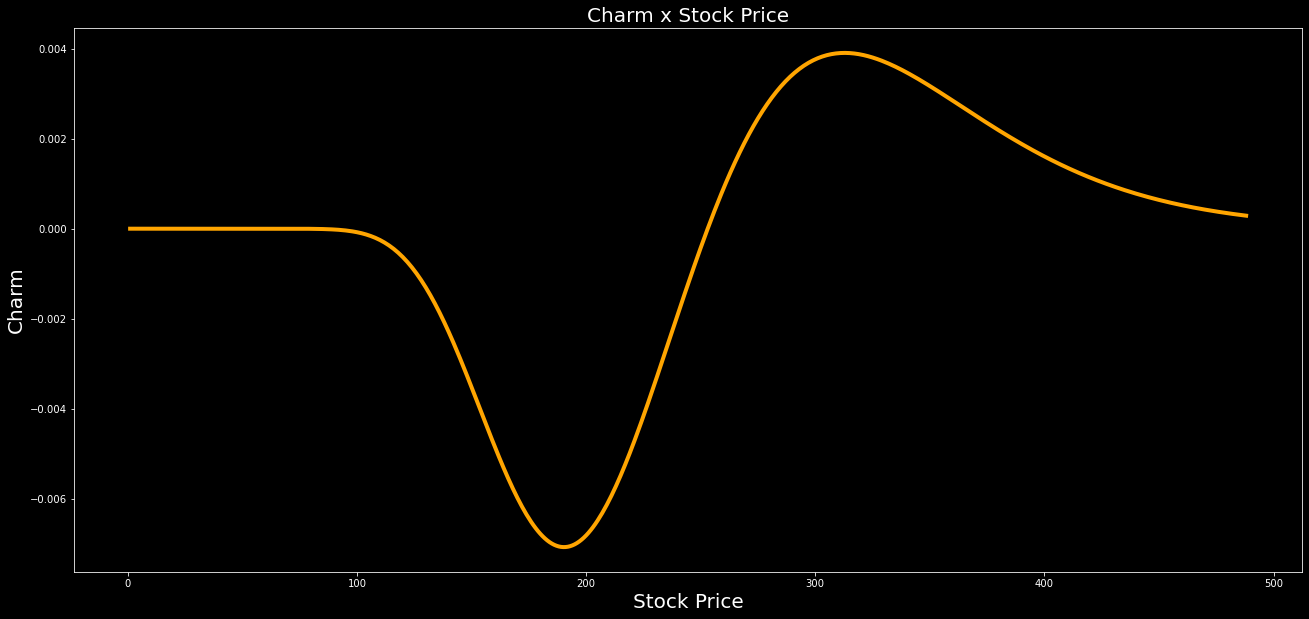

In [300]:
# The Color Effect
plt.figure(figsize=(22,10))
lista_charm=[]
for a in range(int(S_1*2)+1):
    x=(N(charm_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/days_year)
    y=(N(charm_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/days_year)
    lista_charm.append(x+y)
df=pd.DataFrame(pd.Series(lista_charm))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Charm x Stock Price",fontsize=20,color="white")
plt.xlabel("Stock Price",fontsize=20)
plt.ylabel("Charm",fontsize=20)
plt.show()

O gráfico acima representa a dinâmica do Charm a partir da variação do preço do ativo

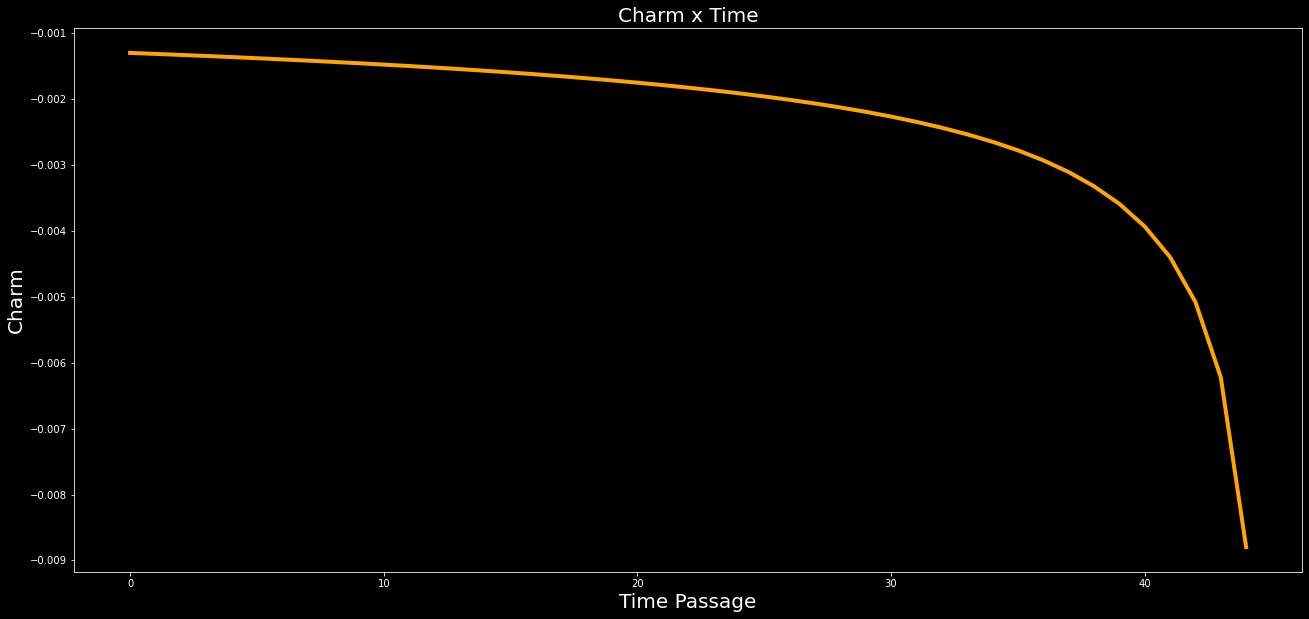

In [301]:
# New Greek
plt.figure(figsize=(22,10))
lista_charm=[]
for a in range(DTE):
    x=N(charm_call.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))/days_year
    y=N(charm_put.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))/days_year
    lista_charm.append(x+y)
df=pd.DataFrame(pd.Series(lista_charm))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Charm x Time",fontsize=20,color="white")
plt.xlabel("Time Passage",fontsize=20)
plt.ylabel("Charm",fontsize=20)
plt.show()

A passagem do tempo faz com que o charm da estrutura vá ficando cada vez mais negativo e movimentos explosivos não corroboram para o operacional da estratégia, por isso finalizamos a estrátegia com 23 dias passados ou com 22 dias para que a opção vença

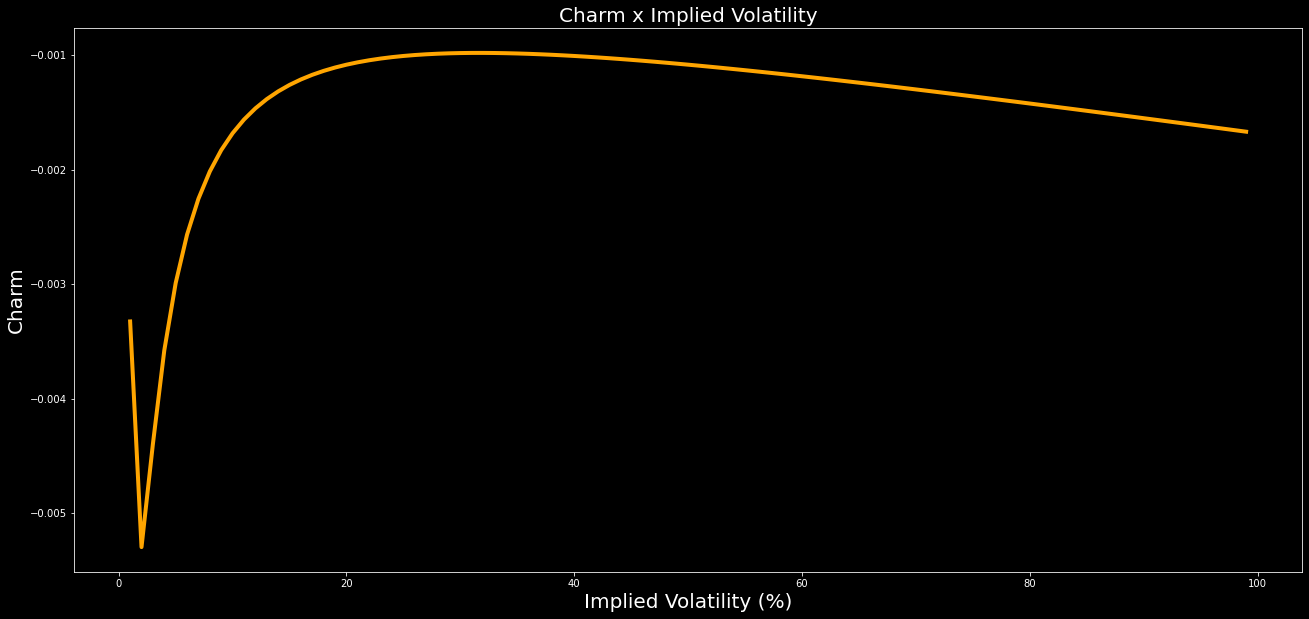

In [302]:
# New Greek
plt.figure(figsize=(22,10))
lista_charm=[]
for a in range(100):
    x=N(charm_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/days_year
    y=N(charm_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/days_year
    lista_charm.append(x+y)
df=pd.DataFrame(pd.Series(lista_charm))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Charm x Implied Volatility",fontsize=20,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=20)
plt.ylabel("Charm",fontsize=20)
plt.show()

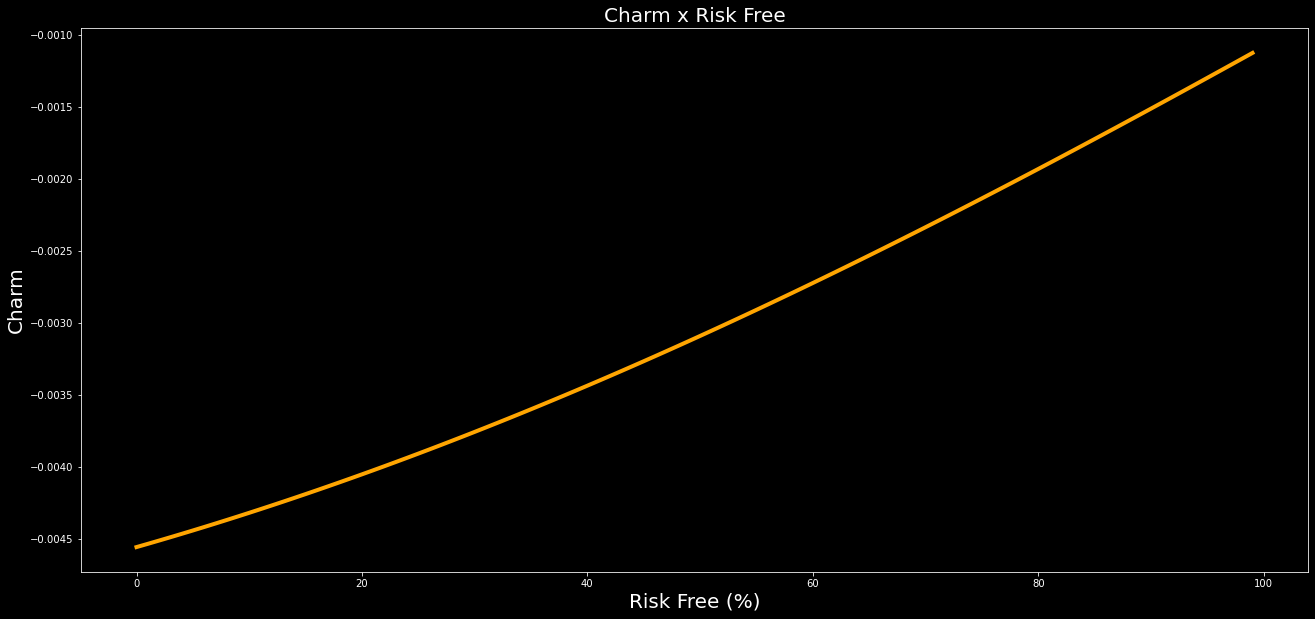

In [303]:
# New greek but not so relevant changes in Charm
plt.figure(figsize=(22,10))
lista_charm=[]
for a in range(100):
    x=(N(charm_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100)))/days_year)
    y=(N(charm_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100)))/days_year)
    lista_charm.append(x+y)
df=pd.DataFrame(pd.Series(lista_charm))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Charm x Risk Free",fontsize=20,color="white")
plt.xlabel("Risk Free (%)",fontsize=20)
plt.ylabel("Charm",fontsize=20)
plt.show()

A taxa de juros varia minimamente o valor do charm de nossa estrutura

## Vanna

$$
{\displaystyle {\text{Vanna}}={\frac {\partial \Delta }{\partial \sigma }}={\frac {\partial {\mathcal {V}}}{\partial S}}={\frac {\partial ^{2}Black Scholes}{\partial S\partial \sigma }}},
$$


O Vanna representa a variação no delta a partir da variação de 1% na volatilidade implícita. é extremamente relevante para estruturas de Delta Hedge como o Gamma Scalping que estamos fazendo, pois é possível compreender como o delta varia a partir da variação da volatilidade implícita, e portanto modelos de predição da mesma podem contribuir para um hedge mais eficiente

## Derivando Black & Scholes para encontrar o Vanna

In [304]:
vanna_call=black_scholes_call.diff(S).diff(v)
vanna_put=black_scholes_put.diff(S).diff(v)
vanna_call

-0.5*sqrt(2)*K*(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*T*v**3) + 0.5*sqrt(2)*K*exp(-T*r)*exp(-(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v**2) + 1.0*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v**2))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi) + 0.5*sqrt(2)*(-1.0*(T*(-q + r + 0.5*v**2) + log(S/K))/v + (T*(-q + r + 0.5*v**2) + log(S/K))**2/(T*v**3))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v) - 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v**2)

In [305]:
vanna_put

0.5*sqrt(2)*K*(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))*(T*(-q + r + 0.5*v**2) + log(S/K))*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*T*v**3) + 0.5*sqrt(2)*K*exp(-T*r)*exp(-(sqrt(T)*v - (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))**2/2)/(sqrt(pi)*S*sqrt(T)*v**2) + 1.0*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v**2))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/sqrt(pi) + 0.5*sqrt(2)*(-1.0*(T*(-q + r + 0.5*v**2) + log(S/K))/v + (T*(-q + r + 0.5*v**2) + log(S/K))**2/(T*v**3))*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v) - 0.5*sqrt(2)*exp(-T*q)*exp(-(T*(-q + r + 0.5*v**2) + log(S/K))**2/(2*T*v**2))/(sqrt(pi)*sqrt(T)*v**2)

## Valor do Vanna

Necessário dividir por 100 para entender o impacto da variação de 1% da volatilidade implícita

In [307]:
N(vanna_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100+N(vanna_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100

0.00110276692170746

cada 1% de variação na volatilidade implícita das opções que constituem o straddle representam uma variação de 0.001 em nosso delta, dessa forma é necessário ficar atento para movimentos explosivos de vol implícita

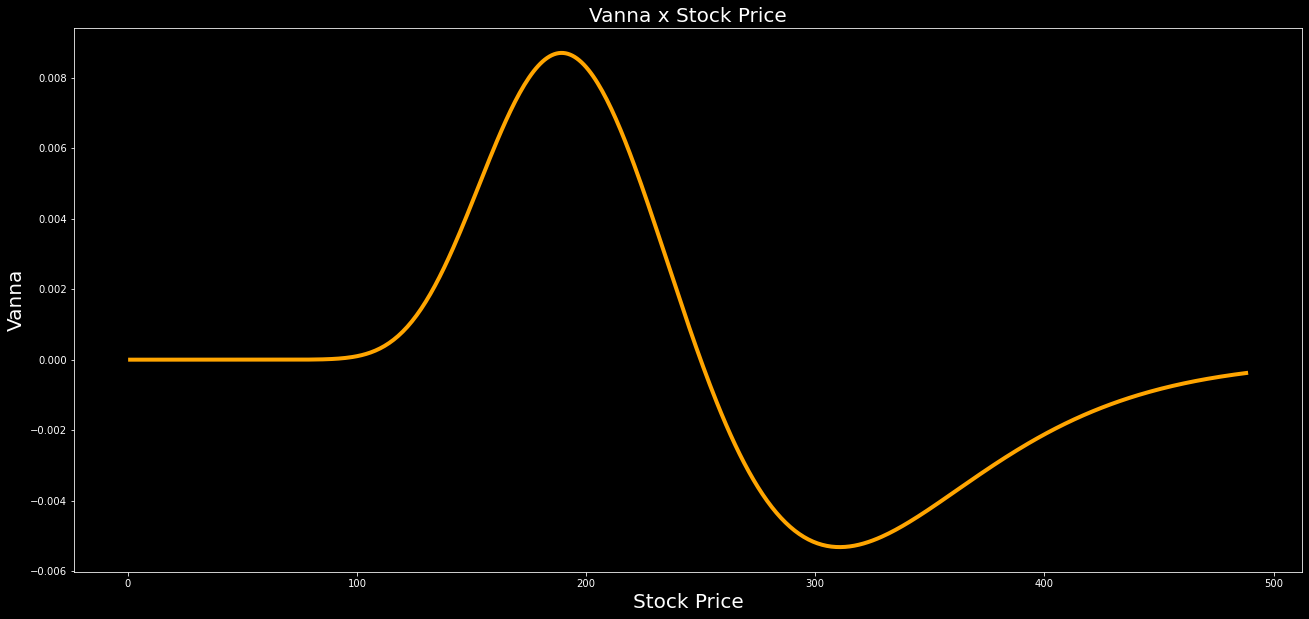

In [308]:
# The Zomma Effect!
plt.figure(figsize=(22,10))
lista_vanna=[]
for a in range(int(S_1*2)+1):
    x=(N(vanna_call.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100)
    y=(N(vanna_put.subs(S,a).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100)
    lista_vanna.append(x+y)
df=pd.DataFrame(pd.Series(lista_vanna))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Vanna x Stock Price",fontsize=20,color="white")
plt.xlabel("Stock Price",fontsize=20)
plt.ylabel("Vanna",fontsize=20)
plt.show()

O gráfico acima demonstra que no período em que ETH-USD mantiver-se com Stock Price de 244 o Vanna é o valor calculado anteriomente, entretanto uma subida de preço do ativo promove uma negativação do Vanna, enquanto que uma queda promove um positivação da grega.

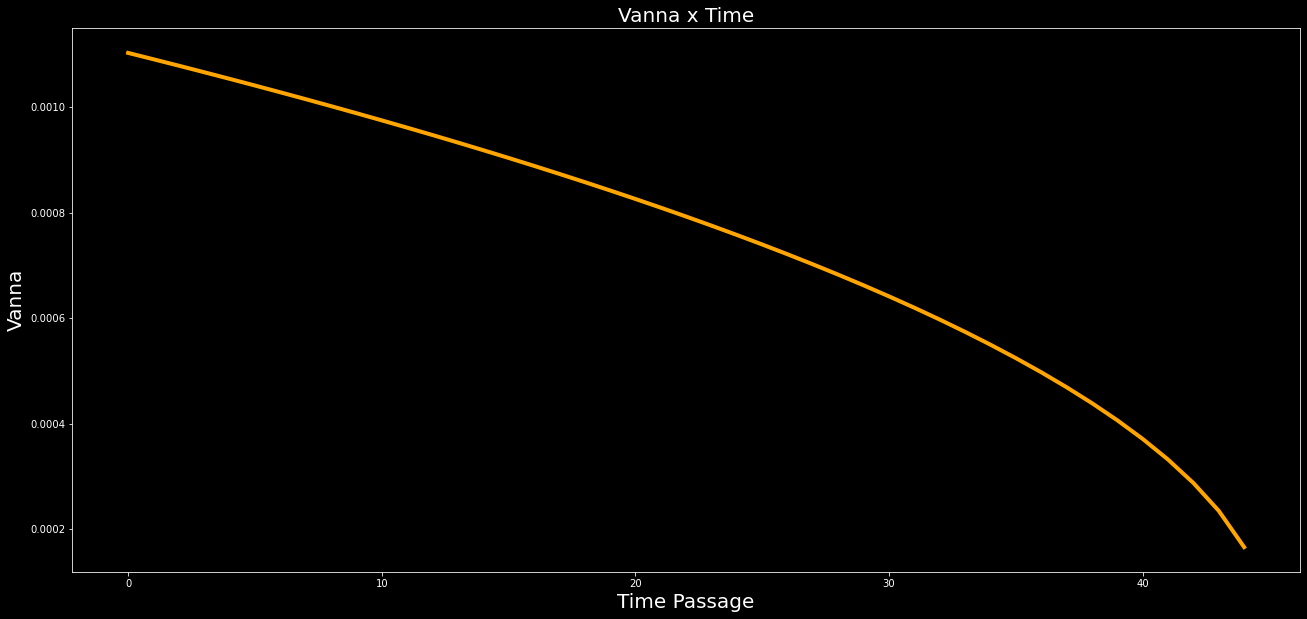

In [309]:
# New Greek!
plt.figure(figsize=(22,10))
lista_vanna=[]
for a in range(DTE):
    x=(N(vanna_call.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100)
    y=(N(vanna_put.subs(S,S_1).subs(K,K_1).subs(T,(DTE-a)/days_year).subs(q,q_1).subs(v,v_1).subs(r,r_1))/100)
    lista_vanna.append(x+y)
df=pd.DataFrame(pd.Series(lista_vanna))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Vanna x Time",fontsize=20,color="white")
plt.xlabel("Time Passage",fontsize=20)
plt.ylabel("Vanna",fontsize=20)
plt.show()

Conforme o tempo passa o valor do Vanna vai sendo diminuido.

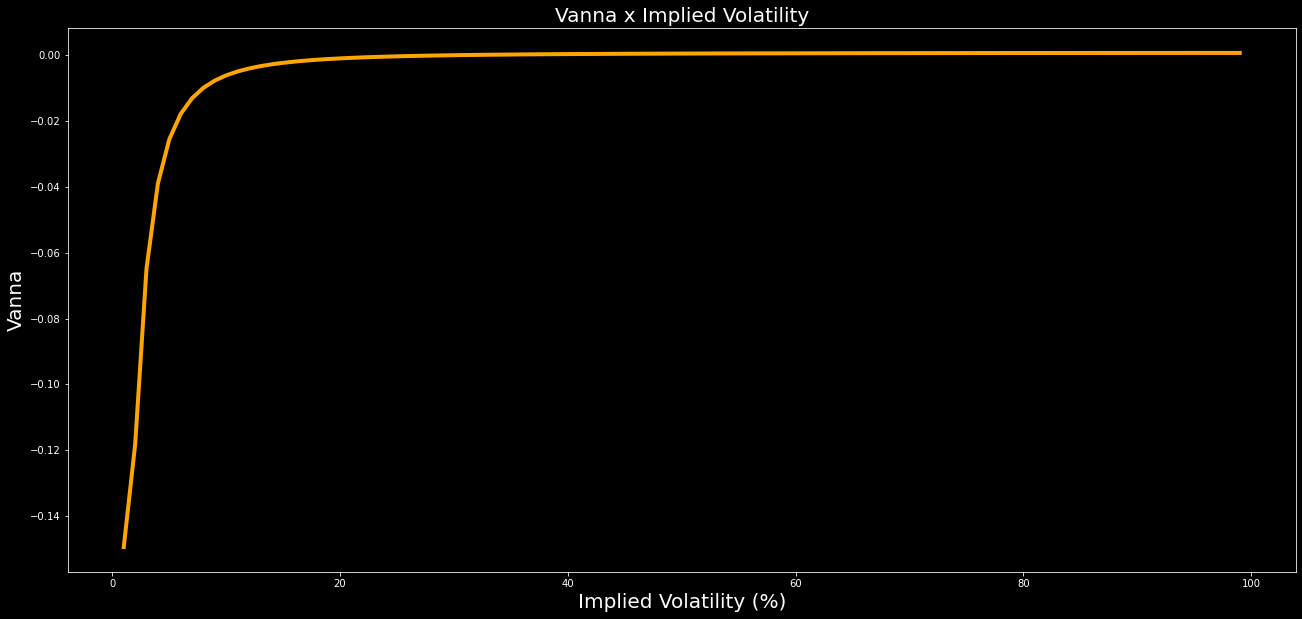

In [77]:
# New Greek
plt.figure(figsize=(22,10))
lista_vanna=[]
for a in range(100):
    x=(N(vanna_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    y=(N(vanna_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,a/100).subs(r,r_1))/100)
    lista_vanna.append(x+y)
df=pd.DataFrame(pd.Series(lista_vanna))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Vanna x Implied Volatility",fontsize=20,color="white")
plt.xlabel("Implied Volatility (%)",fontsize=20)
plt.ylabel("Vanna",fontsize=20)
plt.show()

A volatilidade implícita também afeta o Vanna, como descrito no gráfico acima

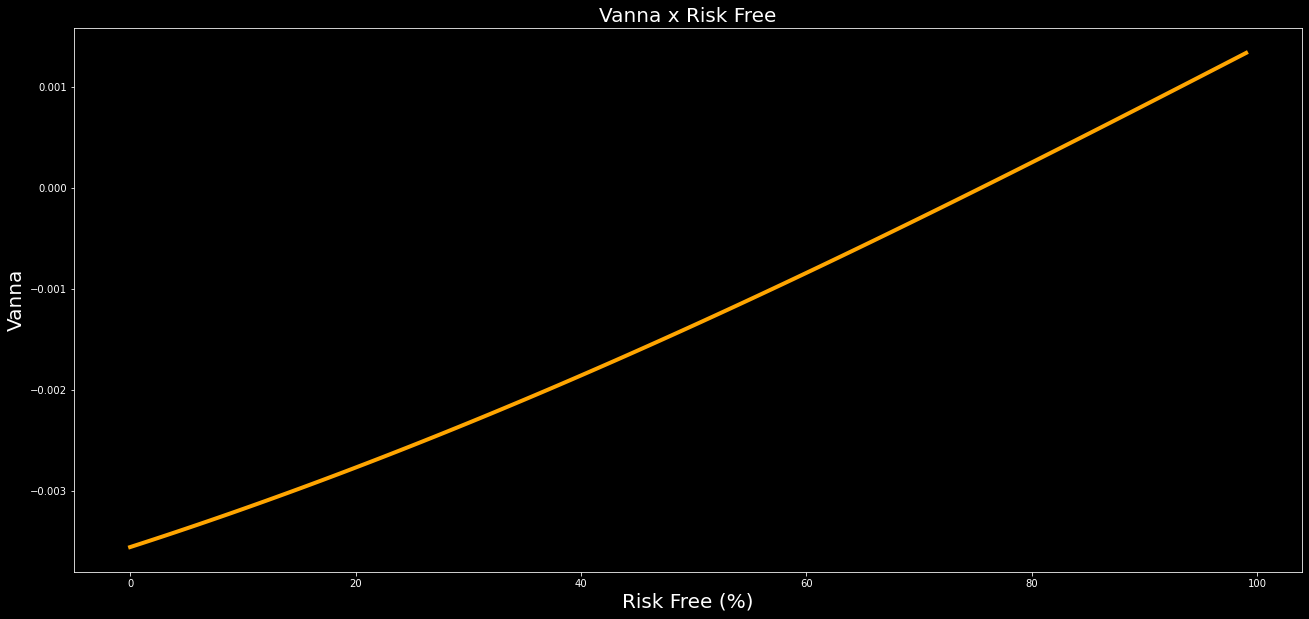

In [56]:
# New greek but not so relevant changes in vanna
plt.figure(figsize=(22,10))
lista_vanna=[]
for a in range(100):
    x=(N(vanna_call.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100)))/100)
    y=(N(vanna_put.subs(S,S_1).subs(K,K_1).subs(T,T_1).subs(q,q_1).subs(v,v_1).subs(r,(100/100-a/100)))/100)
    lista_vanna.append(x+y)
df=pd.DataFrame(pd.Series(lista_vanna))
df=df.rename(columns={0:"x"})
plt.plot(df["x"],color="orange",linewidth=4)
plt.title("Vanna x Risk Free",fontsize=20,color="white")
plt.xlabel("Risk Free (%)",fontsize=20)
plt.ylabel("Vanna",fontsize=20)
plt.show()

O gráfico acima demonstra que o acrescimo de taxa de juros é capaz de inclusive mudar o sinal do Vanna, entretanto a variação da taxa de juros necessita ser bastante elevada para que isso ocorra

## Predição direcional de volatilidade implícita

In [52]:
# Wilder Smoothing Method, ewm span=5 com wilder smoothing fica span de 9
ewma_valores=[ethereum_data["IV"].iloc[10]]
alpha=0.19 # valor otimizado para o máximo hit ratio! e gráfico apresentado na apresentação
for x in range(len(ethereum_data["IV"])):
    if x>10:
        ewma_valores.append(alpha*ethereum_data["IV"].iloc[x]+(1-alpha)*ewma_valores[-1])

Criação de sinal direcional

In [53]:
volatilidades=ethereum_data["IV"][10:]
direcional=[]

for c in range(len(ewma_valores)):
    if ewma_valores[c]<=volatilidades.iloc[c]:# Tendencia de Baixa
        direcional.append(1)
    else:
        direcional.append(-1)

Verificação de acerto no ciclo (23 dias)

In [54]:
direcional_real=[]
for a in range(len(ewma_valores)-23):
    if volatilidades.iloc[a+23]>volatilidades.iloc[a]:
        direcional_real.append(1)
    else:
        direcional_real.append(-1)
pontuacao=0
for b in range(len(direcional_real)):
    if direcional_real[b]==direcional[b]:
        pontuacao+=1
hit_ratio=pontuacao/len(direcional_real)
print(f"Hit Ratio Direcional: {hit_ratio*100:.2f}%")

Hit Ratio Direcional: 56.57%
